In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [41]:
#GLOBAL Variables
BATCH_SIZE = 256
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder ="../GalaxyZoo_kaggle/"


### Load Data and preprocess

In [4]:
Xstd_train = np.load(folder+"train_data.npy")
Xstd_train = Xstd_train.astype(DTYPE_OP)/255
Xstd_train.shape

(50000, 100, 100, 3)

### Load annotations / Generate

In [6]:
train_labels = pd.read_csv(folder+"train_labels.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
print(train_labels.shape)
train_labels.head()

(50000, 38)


,GalaxyID,Answer1.1,Answer1.2,Answer1.3,Answer2.1,Answer2.2,Answer3.1,Answer3.2,Answer4.1,Answer4.2,...,Answer9.3,Answer10.1,Answer10.2,Answer10.3,Answer11.1,Answer11.2,Answer11.3,Answer11.4,Answer11.5,Answer11.6
0,569297,0.083065,0.916935,0.000000,0.023551,0.893384,0.107109,0.786276,0.714189,0.179195,...,0.000000,0.459257,0.254932,0.000000,0.000000,0.504446,0.000000,0.0,0.0,0.209744
1,701332,0.275109,0.713127,0.011765,0.633523,0.079604,0.079604,0.000000,0.000000,0.079604,...,0.499005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,908039,0.411643,0.587223,0.001134,0.234878,0.352345,0.000000,0.352345,0.205471,0.146874,...,0.026647,0.205471,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.205471
3,401459,0.013316,0.986684,0.000000,0.000000,0.986684,0.753419,0.233265,0.986684,0.000000,...,0.000000,0.350273,0.381847,0.254564,0.191225,0.508621,0.095613,0.0,0.0,0.191225
4,607293,0.829407,0.128859,0.041733,0.021519,0.107340,0.000000,0.107340,0.000000,0.107340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


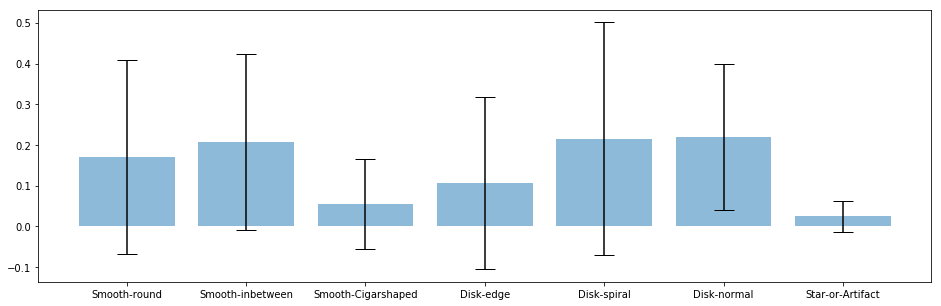

In [7]:
#granulada
labels = ["Smooth-round","Smooth-inbetween","Smooth-Cigarshaped","Disk-edge","Disk-spiral","Disk-normal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer4.1","Answer4.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

In [8]:
#T is aprox 100 000
T_data = 39
r_obs = y_train*T_data  #assuming 39 annotations by data -- maybe sampling..
r_obs = np.round(r_obs).astype('int')

K = r_obs.shape[1]
N = r_obs.shape[0]

print("repeats shape: ",r_obs.shape)
print("Classes: ",K)

repeats shape:  (50000, 7)
Classes:  7


#### Delta Convergence criteria

In [9]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [45]:
model_UB = CNN_simple(Xstd_train.shape[1:],r_obs.shape[1],32, 4, BN=True, drop=0.25,double=True) #wt BN?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)

### Our Proposed

In [15]:
from code.MixtureofGroups import GroupMixtureOpt
from code.utils import *
from code.representation import *

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
mv_onehot = keras.utils.to_categorical(mv_soft.argmax(axis=1))
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Normalized entropy (0-1) of repeats annotations: 0.522018975226096


In [46]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT,metrics=["acc"])
hist=model_mvsoft.fit(Xstd_train, mv_soft, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
#Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Epoch 1/50
50000/50000 [==============================] - 100s 2ms/step - loss: 1.6470 - acc: 0.4338
Epoch 2/50
50000/50000 [==============================] - 93s 2ms/step - loss: 1.3846 - acc: 0.5686
Epoch 3/50
 7936/50000 [===>..........................] - ETA: 1:18 - loss: 1.3444 - acc: 0.6023

KeyboardInterrupt: 

In [ ]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.005396 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7649964  0.35427967 0.05306005 0.08938941 0.32689986]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.57 sec)	logL: -7404.934	
Finished training!


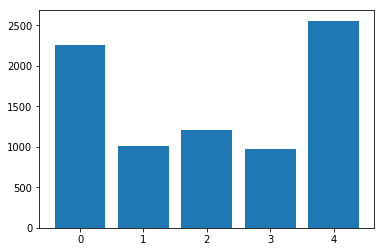

<BarContainer object of 5 artists>

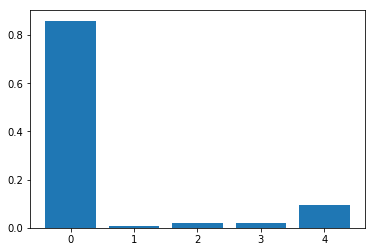

In [16]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL
                               ,cluster=True)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [31]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

R_total= r_obs.sum(axis=-1).sum(axis=-1)
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
        
        #to uniform groups...
        gMixture_Global.define_priors("laplace")
        gMixture_Global.define_priors(np.tile(R_total*0.1/M_seted,gMixture_Global.M)) 
        
        gMixture_Global.lambda_random = True 
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003649 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3260.276	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2203.735	Tol1: 0.32406	Tol2: 0.70936	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.212	Tol1: 0.09825	Tol2: 0.15927	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1902.811	Tol1: 0.04247	Tol2: 0.11973	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.444	Tol1: 0.02594	Tol2: 0.06754	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1775.781	Tol1: 0.04190	Tol2: 0.05046	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1685.262	Tol1: 0.02071	Tol2: 0.04177	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1655.775	Tol1: 0.01750	Tol2: 0.03944	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.850	Tol1: 0.01385	Tol2: 0.03764	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1605.052	Tol1: 0.01702	Tol2: 0.05111	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1587.118	Tol1: 0.01117	Tol2: 0.05005	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1573.107	Tol1: 0.00883	Tol2: 0.04193	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1554.219	Tol1: 0.01201	Tol2: 0.03650	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1542.406	Tol1: 0.00760	Tol2: 0.03191	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1528.562	Tol1: 0.00

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003971 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.59]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3011.392	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2115.873	Tol1: 0.29738	Tol2: 0.39124	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1924.810	Tol1: 0.09030	Tol2: 0.18874	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.941	Tol1: 0.03682	Tol2: 0.14168	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.691	Tol1: 0.04005	Tol2: 0.10433	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1732.332	Tol1: 0.02661	Tol2: 0.07472	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL:

M step: done,  E step: done //  (in 0.53 sec)	logL: -2903.953	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1932.872	Tol1: 0.33440	Tol2: 0.82241	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.271	Tol1: 0.08154	Tol2: 0.22462	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.312	Tol1: 0.05236	Tol2: 0.11730	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1631.710	Tol1: 0.03008	Tol2: 0.05951	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1600.297	Tol1: 0.01925	Tol2: 0.04784	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1569.011	Tol1: 0.01955	Tol2: 0.05087	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1537.785	Tol1: 0.01990	Tol2: 0.03448	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1512.948	Tol1: 0.01615	Tol2: 0.03312	Tol3: 0.00000	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.07 sec)	logL: -1665.497	Tol1: 0.02340	Tol2: 0.04512	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1631.922	Tol1: 0.02016	Tol2: 0.03993	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1598.853	Tol1: 0.02026	Tol2: 0.03036	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1572.906	Tol1: 0.01623	Tol2: 0.03485	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1549.085	Tol1: 0.01514	Tol2: 0.02765	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.12]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3066.802	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2105.010	Tol1: 0.31361	Tol2: 0.87251	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	log

M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.458	Tol1: 0.02126	Tol2: 0.05115	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1613.068	Tol1: 0.02443	Tol2: 0.03081	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1583.799	Tol1: 0.01815	Tol2: 0.03058	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1563.113	Tol1: 0.01306	Tol2: 0.03375	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1541.486	Tol1: 0.01384	Tol2: 0.02629	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.12]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3204.200	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2021.954	Tol1: 0.36897	Tol2: 1.11155	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	l

M step: done,  E step: done //  (in 0.07 sec)	logL: -1992.400	Tol1: 0.26433	Tol2: 0.48447	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1822.188	Tol1: 0.08543	Tol2: 0.12262	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1738.411	Tol1: 0.04598	Tol2: 0.14596	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1684.825	Tol1: 0.03082	Tol2: 0.07265	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1629.713	Tol1: 0.03271	Tol2: 0.04093	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1594.235	Tol1: 0.02177	Tol2: 0.03637	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1564.033	Tol1: 0.01894	Tol2: 0.03206	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1540.763	Tol1: 0.01488	Tol2: 0.03230	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1522.017	Tol1: 0.01217	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1656.753	Tol1: 0.03383	Tol2: 0.06587	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1616.625	Tol1: 0.02422	Tol2: 0.05562	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1580.962	Tol1: 0.02206	Tol2: 0.04182	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1555.973	Tol1: 0.01581	Tol2: 0.02338	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.77]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3251.488	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2186.966	Tol1: 0.32740	Tol2: 0.49939	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1919.904	Tol1: 0.12212	Tol2: 0.25524	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL

M step: done,  E step: done //  (in 0.07 sec)	logL: -1795.022	Tol1: 0.04558	Tol2: 0.10245	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1746.638	Tol1: 0.02695	Tol2: 0.06686	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1696.566	Tol1: 0.02867	Tol2: 0.04770	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1653.978	Tol1: 0.02510	Tol2: 0.03720	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1621.597	Tol1: 0.01958	Tol2: 0.03618	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1585.698	Tol1: 0.02214	Tol2: 0.02164	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2898.897	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL

M step: done,  E step: done //  (in 0.53 sec)	logL: -3168.476	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2164.043	Tol1: 0.31701	Tol2: 0.82758	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1948.156	Tol1: 0.09976	Tol2: 0.19210	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1853.338	Tol1: 0.04867	Tol2: 0.11923	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1788.393	Tol1: 0.03504	Tol2: 0.07408	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1727.642	Tol1: 0.03397	Tol2: 0.04298	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1677.763	Tol1: 0.02887	Tol2: 0.04484	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1633.466	Tol1: 0.02640	Tol2: 0.04281	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1598.908	Tol1: 0.02116	Tol2: 0.04320	Tol3: 0.00000	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.08 sec)	logL: -1837.092	Tol1: 0.05055	Tol2: 0.13220	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.217	Tol1: 0.04021	Tol2: 0.07142	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1713.080	Tol1: 0.02844	Tol2: 0.05664	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1658.004	Tol1: 0.03215	Tol2: 0.04134	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1618.763	Tol1: 0.02367	Tol2: 0.04025	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1583.847	Tol1: 0.02157	Tol2: 0.04489	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1558.795	Tol1: 0.01582	Tol2: 0.03362	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1535.997	Tol1: 0.01463	Tol2: 0.02519	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda

M step: done,  E step: done //  (in 0.08 sec)	logL: -1673.025	Tol1: 0.02155	Tol2: 0.05741	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1630.861	Tol1: 0.02520	Tol2: 0.04156	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1589.511	Tol1: 0.02535	Tol2: 0.02898	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.75]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3062.608	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2170.647	Tol1: 0.29124	Tol2: 0.67679	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1994.295	Tol1: 0.08124	Tol2: 0.23714	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1897.125	Tol1: 0.04872	Tol2: 0.17081	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL

M step: done,  E step: done //  (in 0.07 sec)	logL: -1635.319	Tol1: 0.02985	Tol2: 0.06807	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1587.295	Tol1: 0.02937	Tol2: 0.04890	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1556.324	Tol1: 0.01951	Tol2: 0.03678	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1528.786	Tol1: 0.01769	Tol2: 0.02380	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -2980.006	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2043.225	Tol1: 0.31436	Tol2: 1.18746	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1849.881	Tol1: 0.09463	Tol2: 0.26575	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	log

M step: done,  E step: done //  (in 0.55 sec)	logL: -3668.794	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2445.596	Tol1: 0.33341	Tol2: 0.72898	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2133.680	Tol1: 0.12754	Tol2: 0.21518	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1995.522	Tol1: 0.06475	Tol2: 0.17036	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1884.303	Tol1: 0.05573	Tol2: 0.09881	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1802.405	Tol1: 0.04346	Tol2: 0.06094	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1730.924	Tol1: 0.03966	Tol2: 0.06279	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1691.519	Tol1: 0.02277	Tol2: 0.04358	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1657.888	Tol1: 0.01988	Tol2: 0.03850	Tol3: 0.00000	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.07 sec)	logL: -2011.715	Tol1: 0.13026	Tol2: 0.17087	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1842.773	Tol1: 0.08398	Tol2: 0.17948	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.936	Tol1: 0.05038	Tol2: 0.11566	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1680.339	Tol1: 0.03977	Tol2: 0.08793	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1644.070	Tol1: 0.02158	Tol2: 0.06118	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1604.060	Tol1: 0.02434	Tol2: 0.04214	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1568.047	Tol1: 0.02245	Tol2: 0.02802	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.88]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: 

M step: done,  E step: done //  (in 0.08 sec)	logL: -1823.209	Tol1: 0.03313	Tol2: 0.06047	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1768.498	Tol1: 0.03001	Tol2: 0.06277	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1715.348	Tol1: 0.03005	Tol2: 0.04115	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1661.041	Tol1: 0.03166	Tol2: 0.03562	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1622.126	Tol1: 0.02343	Tol2: 0.02804	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3107.668	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2147.666	Tol1: 0.30891	Tol2: 0.78924	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL

M step: done,  E step: done //  (in 0.55 sec)	logL: -3319.094	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2352.671	Tol1: 0.29117	Tol2: 0.76725	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2128.663	Tol1: 0.09521	Tol2: 0.15781	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.402	Tol1: 0.06636	Tol2: 0.16646	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1911.357	Tol1: 0.03826	Tol2: 0.13665	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1825.091	Tol1: 0.04513	Tol2: 0.08470	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1765.388	Tol1: 0.03271	Tol2: 0.06361	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.253	Tol1: 0.04029	Tol2: 0.05857	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1641.427	Tol1: 0.03118	Tol2: 0.06325	Tol3: 0.00000	
Iter 10/50
M step

Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.004806 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.93]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3073.801	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2224.175	Tol1: 0.27641	Tol2: 0.44091	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1991.965	Tol1: 0.10440	Tol2: 0.17122	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1893.204	Tol1: 0.04958	Tol2: 0.12623	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1828.528	Tol1: 0.03416	Tol2: 0.07335	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1781.571	Tol1: 0.02568	Tol2: 0.05600	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1646.861	Tol1: 0.02584	Tol2: 0.03970	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1611.707	Tol1: 0.02135	Tol2: 0.03575	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1583.092	Tol1: 0.01775	Tol2: 0.02606	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.79]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3150.420	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2236.716	Tol1: 0.29003	Tol2: 0.57076	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1976.959	Tol1: 0.11613	Tol2: 0.18482	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1857.605	Tol1: 0.06037	Tol2: 0.16937	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL

M step: done,  E step: done //  (in 0.05 sec)	logL: -1850.515	Tol1: 0.02736	Tol2: 0.10449	Tol3: 0.05178	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1803.459	Tol1: 0.02543	Tol2: 0.07908	Tol3: 0.05019	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1753.065	Tol1: 0.02794	Tol2: 0.06575	Tol3: 0.05094	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.577	Tol1: 0.02766	Tol2: 0.05998	Tol3: 0.04776	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.024	Tol1: 0.02086	Tol2: 0.05987	Tol3: 0.04544	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1640.019	Tol1: 0.01738	Tol2: 0.05227	Tol3: 0.04542	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1614.267	Tol1: 0.01570	Tol2: 0.04493	Tol3: 0.04363	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1594.470	Tol1: 0.01226	Tol2: 0.04282	Tol3: 0.03999	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1578.754	Tol1: 0.00986	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.605	Tol1: 0.01283	Tol2: 0.05703	Tol3: 0.03666	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1683.245	Tol1: 0.01195	Tol2: 0.05116	Tol3: 0.03819	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.413	Tol1: 0.01416	Tol2: 0.04636	Tol3: 0.03839	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1639.322	Tol1: 0.01211	Tol2: 0.04858	Tol3: 0.03414	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1629.165	Tol1: 0.00620	Tol2: 0.03719	Tol3: 0.03174	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1617.029	Tol1: 0.00745	Tol2: 0.03643	Tol3: 0.03072	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1603.943	Tol1: 0.00809	Tol2: 0.03485	Tol3: 0.03015	
Iter 16/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1592.940	Tol1: 0.00686	Tol2: 0.03379	Tol3: 0.02678	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1584.634	Tol1: 0.00

M step: done,  E step: done //  (in 0.06 sec)	logL: -1595.431	Tol1: 0.00716	Tol2: 0.03295	Tol3: 0.02803	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1587.211	Tol1: 0.00515	Tol2: 0.02658	Tol3: 0.02628	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78 0.16]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3377.929	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2436.381	Tol1: 0.27874	Tol2: 0.44749	Tol3: 0.34321	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2122.369	Tol1: 0.12888	Tol2: 0.22465	Tol3: 0.06365	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1979.266	Tol1: 0.06743	Tol2: 0.16506	Tol3: 0.02707	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1874.314	Tol1: 0.05303	Tol2: 0.12055	Tol3: 0.04333	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65 0.84]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.47 sec)	logL: -3024.192	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2274.611	Tol1: 0.24786	Tol2: 0.35966	Tol3: 0.28997	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2046.933	Tol1: 0.10010	Tol2: 0.18628	Tol3: 0.08383	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1939.351	Tol1: 0.05256	Tol2: 0.13046	Tol3: 0.05026	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.050	Tol1: 0.03728	Tol2: 0.09677	Tol3: 0.05140	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1811.353	Tol1: 0.02983	Tol2: 0.08163	Tol3: 0.04886	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.068	Tol1: 0.02003	Tol2: 0.07011	Tol3: 0.04780	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1

M step: done,  E step: done //  (in 0.05 sec)	logL: -1814.290	Tol1: 0.03390	Tol2: 0.08560	Tol3: 0.02993	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1758.411	Tol1: 0.03080	Tol2: 0.06574	Tol3: 0.03599	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1713.092	Tol1: 0.02577	Tol2: 0.05801	Tol3: 0.03848	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1674.846	Tol1: 0.02233	Tol2: 0.05294	Tol3: 0.04144	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1627.907	Tol1: 0.02803	Tol2: 0.04733	Tol3: 0.04179	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1592.934	Tol1: 0.02148	Tol2: 0.06140	Tol3: 0.03769	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1568.649	Tol1: 0.01525	Tol2: 0.04566	Tol3: 0.03715	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1548.842	Tol1: 0.01263	Tol2: 0.04299	Tol3: 0.03654	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1522.134	Tol1: 0.01724

M step: done,  E step: done //  (in 0.07 sec)	logL: -1714.895	Tol1: 0.02879	Tol2: 0.07138	Tol3: 0.05439	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1674.649	Tol1: 0.02347	Tol2: 0.06148	Tol3: 0.05687	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.065	Tol1: 0.02065	Tol2: 0.05182	Tol3: 0.05299	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1614.632	Tol1: 0.01551	Tol2: 0.05566	Tol3: 0.04829	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1586.950	Tol1: 0.01714	Tol2: 0.04295	Tol3: 0.04450	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1562.271	Tol1: 0.01555	Tol2: 0.04184	Tol3: 0.03976	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1544.822	Tol1: 0.01117	Tol2: 0.04159	Tol3: 0.03665	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1526.578	Tol1: 0.01181	Tol2: 0.03655	Tol3: 0.03344	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1513.422	Tol1: 0.0086

M step: done,  E step: done //  (in 0.05 sec)	logL: -1582.951	Tol1: 0.01205	Tol2: 0.05206	Tol3: 0.04208	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1561.539	Tol1: 0.01353	Tol2: 0.04067	Tol3: 0.03849	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1544.234	Tol1: 0.01108	Tol2: 0.04180	Tol3: 0.03668	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1525.952	Tol1: 0.01184	Tol2: 0.03766	Tol3: 0.03317	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1509.413	Tol1: 0.01084	Tol2: 0.03560	Tol3: 0.03032	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1490.199	Tol1: 0.01273	Tol2: 0.03650	Tol3: 0.02799	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1471.157	Tol1: 0.01278	Tol2: 0.03579	Tol3: 0.02532	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1461.208	Tol1: 0.00676	Tol2: 0.03186	Tol3: 0.02446	
Iter 19/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1446.895	Tol1: 0.00

M step: done,  E step: done //  (in 0.05 sec)	logL: -1558.272	Tol1: 0.01121	Tol2: 0.03707	Tol3: 0.03291	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1540.434	Tol1: 0.01145	Tol2: 0.03954	Tol3: 0.03015	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1524.773	Tol1: 0.01017	Tol2: 0.03863	Tol3: 0.02815	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1511.375	Tol1: 0.00879	Tol2: 0.03669	Tol3: 0.02750	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1497.896	Tol1: 0.00892	Tol2: 0.03229	Tol3: 0.02616	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1482.202	Tol1: 0.01048	Tol2: 0.03433	Tol3: 0.02387	
Iter 20/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1468.269	Tol1: 0.00940	Tol2: 0.03085	Tol3: 0.02223	
Iter 21/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1456.157	Tol1: 0.00825	Tol2: 0.02872	Tol3: 0.02110	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
La

M step: done,  E step: done //  (in 0.50 sec)	logL: -3136.597	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2290.530	Tol1: 0.26974	Tol2: 0.44989	Tol3: 0.35416	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2091.867	Tol1: 0.08673	Tol2: 0.24374	Tol3: 0.04973	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1958.842	Tol1: 0.06359	Tol2: 0.13912	Tol3: 0.05499	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1870.074	Tol1: 0.04532	Tol2: 0.11727	Tol3: 0.04556	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1800.193	Tol1: 0.03737	Tol2: 0.09621	Tol3: 0.04328	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1745.925	Tol1: 0.03015	Tol2: 0.07671	Tol3: 0.04150	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1708.310	Tol1: 0.02154	Tol2: 0.06007	Tol3: 0.04257	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1669.120	Tol1: 0.02294	Tol2: 0.05313	Tol3: 0.04342	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.09 sec)	logL: -1704.257	Tol1: 0.02497	Tol2: 0.05704	Tol3: 0.03344	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1668.765	Tol1: 0.02083	Tol2: 0.05485	Tol3: 0.03416	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1642.684	Tol1: 0.01563	Tol2: 0.04541	Tol3: 0.03401	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1618.349	Tol1: 0.01481	Tol2: 0.03981	Tol3: 0.03310	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1601.818	Tol1: 0.01021	Tol2: 0.03871	Tol3: 0.03436	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1583.905	Tol1: 0.01118	Tol2: 0.03803	Tol3: 0.03118	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1565.098	Tol1: 0.01187	Tol2: 0.03545	Tol3: 0.03008	
Iter 15/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1549.929	Tol1: 0.00969	Tol2: 0.03695	Tol3: 0.02642	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1533.386	Tol1: 0.010

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.83 0.09]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -2794.794	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2188.588	Tol1: 0.21691	Tol2: 0.32082	Tol3: 0.23916	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1999.600	Tol1: 0.08635	Tol2: 0.18761	Tol3: 0.08890	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.608	Tol1: 0.05401	Tol2: 0.12577	Tol3: 0.06865	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.112	Tol1: 0.03885	Tol2: 0.09894	Tol3: 0.06167	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.561	Tol1: 0.03825	Tol2: 0.08108	Tol3: 0.05734	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.514	Tol1: 0.02919	Tol2: 0.07845	Tol3: 0.05153	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1

M step: done,  E step: done //  (in 0.05 sec)	logL: -2230.249	Tol1: 0.29216	Tol2: 0.47299	Tol3: 0.30708	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2002.147	Tol1: 0.10228	Tol2: 0.16901	Tol3: 0.08374	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1882.444	Tol1: 0.05979	Tol2: 0.12445	Tol3: 0.06029	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1811.954	Tol1: 0.03745	Tol2: 0.09772	Tol3: 0.04905	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -1749.263	Tol1: 0.03460	Tol2: 0.08604	Tol3: 0.05011	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.074	Tol1: 0.02640	Tol2: 0.07414	Tol3: 0.05129	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.880	Tol1: 0.02360	Tol2: 0.05377	Tol3: 0.05009	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1629.597	Tol1: 0.02002	Tol2: 0.05142	Tol3: 0.04554	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1601.642	Tol1: 0.01715	Tol

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31 0.28]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3156.983	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2231.787	Tol1: 0.29306	Tol2: 0.56375	Tol3: 0.37168	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1963.573	Tol1: 0.12018	Tol2: 0.18996	Tol3: 0.05213	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1848.241	Tol1: 0.05874	Tol2: 0.15218	Tol3: 0.03138	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1796.942	Tol1: 0.02776	Tol2: 0.11232	Tol3: 0.05006	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.510	Tol1: 0.02695	Tol2: 0.08575	Tol3: 0.05562	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.889	Tol1: 0.02323	Tol2: 0.06673	Tol3: 0.05427	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.100	Tol1: 0.02037	T

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28 0.94]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3222.913	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2165.431	Tol1: 0.32811	Tol2: 0.42227	Tol3: 0.36751	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1940.735	Tol1: 0.10377	Tol2: 0.22749	Tol3: 0.04444	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1837.492	Tol1: 0.05320	Tol2: 0.13556	Tol3: 0.04693	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1772.426	Tol1: 0.03541	Tol2: 0.08959	Tol3: 0.04542	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1722.561	Tol1: 0.02813	Tol2: 0.07219	Tol3: 0.04524	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.664	Tol1: 0.02374	Tol2: 0.06019	Tol3: 0.04760	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1

M step: done,  E step: done //  (in 0.06 sec)	logL: -1952.108	Tol1: 0.11471	Tol2: 0.26943	Tol3: 0.06562	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1847.447	Tol1: 0.05361	Tol2: 0.15905	Tol3: 0.03720	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.348	Tol1: 0.02549	Tol2: 0.09583	Tol3: 0.02915	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1759.997	Tol1: 0.02241	Tol2: 0.06526	Tol3: 0.03585	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1716.867	Tol1: 0.02451	Tol2: 0.05639	Tol3: 0.03301	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1682.549	Tol1: 0.01999	Tol2: 0.05199	Tol3: 0.03695	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.489	Tol1: 0.01608	Tol2: 0.04928	Tol3: 0.03886	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1632.536	Tol1: 0.01386	Tol2: 0.04485	Tol3: 0.03538	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1614.894	Tol1: 0.01081	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.514	Tol1: 0.02310	Tol2: 0.05506	Tol3: 0.04569	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1634.841	Tol1: 0.01842	Tol2: 0.05890	Tol3: 0.04210	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1603.946	Tol1: 0.01890	Tol2: 0.05499	Tol3: 0.04057	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1577.304	Tol1: 0.01661	Tol2: 0.04683	Tol3: 0.03742	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1550.730	Tol1: 0.01685	Tol2: 0.04710	Tol3: 0.03449	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1527.223	Tol1: 0.01516	Tol2: 0.03842	Tol3: 0.03020	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1510.084	Tol1: 0.01122	Tol2: 0.04451	Tol3: 0.02834	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1490.203	Tol1: 0.01317	Tol2: 0.03753	Tol3: 0.02643	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1471.166	Tol1: 0.012

M step: done,  E step: done //  (in 0.05 sec)	logL: -1442.263	Tol1: 0.01195	Tol2: 0.02983	Tol3: 0.02530	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15 0.68]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3355.288	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2304.083	Tol1: 0.31330	Tol2: 0.62323	Tol3: 0.49761	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2034.536	Tol1: 0.11699	Tol2: 0.18679	Tol3: 0.05036	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.768	Tol1: 0.07656	Tol2: 0.16320	Tol3: 0.02241	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1800.396	Tol1: 0.04171	Tol2: 0.11123	Tol3: 0.02116	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.826	Tol1: 0.03198	Tol2: 0.08261	Tol3: 0.03344	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)

M step: done,  E step: done //  (in 0.05 sec)	logL: -1782.809	Tol1: 0.02765	Tol2: 0.10753	Tol3: 0.04230	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1735.530	Tol1: 0.02652	Tol2: 0.07663	Tol3: 0.04247	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1700.201	Tol1: 0.02036	Tol2: 0.06242	Tol3: 0.03949	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1668.628	Tol1: 0.01857	Tol2: 0.06031	Tol3: 0.04217	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1644.919	Tol1: 0.01421	Tol2: 0.04831	Tol3: 0.04272	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1620.855	Tol1: 0.01463	Tol2: 0.04980	Tol3: 0.04219	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1593.512	Tol1: 0.01687	Tol2: 0.04452	Tol3: 0.03962	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1577.465	Tol1: 0.01007	Tol2: 0.04744	Tol3: 0.03830	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1559.921	Tol1: 0.01112	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1895.493	Tol1: 0.05282	Tol2: 0.16263	Tol3: 0.01867	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1827.743	Tol1: 0.03574	Tol2: 0.10131	Tol3: 0.03038	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1783.533	Tol1: 0.02419	Tol2: 0.07662	Tol3: 0.03256	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1735.399	Tol1: 0.02699	Tol2: 0.06939	Tol3: 0.03778	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1698.534	Tol1: 0.02124	Tol2: 0.07126	Tol3: 0.03837	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.292	Tol1: 0.01957	Tol2: 0.05861	Tol3: 0.03961	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1637.183	Tol1: 0.01688	Tol2: 0.05299	Tol3: 0.03796	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1613.437	Tol1: 0.01450	Tol2: 0.05109	Tol3: 0.03784	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1598.079	Tol1: 0.00952	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1660.674	Tol1: 0.01975	Tol2: 0.06001	Tol3: 0.05452	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1635.343	Tol1: 0.01525	Tol2: 0.05371	Tol3: 0.04932	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1616.208	Tol1: 0.01170	Tol2: 0.04601	Tol3: 0.04589	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1596.207	Tol1: 0.01238	Tol2: 0.04474	Tol3: 0.04128	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1580.737	Tol1: 0.00969	Tol2: 0.04097	Tol3: 0.03686	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1565.900	Tol1: 0.00939	Tol2: 0.03649	Tol3: 0.03516	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1548.447	Tol1: 0.01115	Tol2: 0.03325	Tol3: 0.03241	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1538.873	Tol1: 0.00618	Tol2: 0.03159	Tol3: 0.02986	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1527.334	Tol1: 0.007

M step: done,  E step: done //  (in 0.05 sec)	logL: -1484.157	Tol1: 0.01143	Tol2: 0.03774	Tol3: 0.02673	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1473.990	Tol1: 0.00685	Tol2: 0.03124	Tol3: 0.02472	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1465.282	Tol1: 0.00591	Tol2: 0.03063	Tol3: 0.02348	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1454.853	Tol1: 0.00712	Tol2: 0.02534	Tol3: 0.02174	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.86 0.56]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2988.452	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2296.958	Tol1: 0.23139	Tol2: 0.32140	Tol3: 0.28602	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2061.928	Tol1: 0.10232	Tol2: 0.20215	Tol3: 0.05407	
Iter 4/50
M step: done,  E step: done //  (in 0.05 s

M step: done,  E step: done //  (in 0.08 sec)	logL: -1585.499	Tol1: 0.00814	Tol2: 0.04081	Tol3: 0.03158	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1576.603	Tol1: 0.00561	Tol2: 0.04091	Tol3: 0.03082	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1564.457	Tol1: 0.00770	Tol2: 0.03466	Tol3: 0.02829	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1553.193	Tol1: 0.00720	Tol2: 0.02829	Tol3: 0.02596	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29 0.15]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2852.363	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2128.556	Tol1: 0.25376	Tol2: 0.44183	Tol3: 0.30812	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1979.518	Tol1: 0.07002	Tol2: 0.18658	Tol3: 0.08950	
Iter 4/50
M step: done,  E step: done //  (in 0.05 s

M step: done,  E step: done //  (in 0.05 sec)	logL: -1526.825	Tol1: 0.01470	Tol2: 0.03943	Tol3: 0.03289	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1511.379	Tol1: 0.01012	Tol2: 0.04048	Tol3: 0.03070	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1502.486	Tol1: 0.00588	Tol2: 0.03400	Tol3: 0.02837	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1491.013	Tol1: 0.00764	Tol2: 0.03853	Tol3: 0.02664	
Iter 18/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1478.195	Tol1: 0.00860	Tol2: 0.02975	Tol3: 0.02432	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16 0.12]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3044.186	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2203.337	Tol1: 0.27621	Tol2: 0.70500	Tol3: 0.42539	
Iter 3/50
M step: done,  E step: done //  (in 0.05 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1505.438	Tol1: 0.01176	Tol2: 0.04147	Tol3: 0.03586	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1489.011	Tol1: 0.01091	Tol2: 0.03515	Tol3: 0.03261	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1472.547	Tol1: 0.01106	Tol2: 0.03467	Tol3: 0.02895	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1456.597	Tol1: 0.01083	Tol2: 0.03458	Tol3: 0.02827	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1444.815	Tol1: 0.00809	Tol2: 0.02983	Tol3: 0.02648	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.59 0.24]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -2877.825	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2142.886	Tol1: 0.25538	Tol2: 0.40947	Tol3: 0.33655	
Iter 3/50
M step: done,  E step: done //  (in 0.05 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1570.587	Tol1: 0.00827	Tol2: 0.03036	Tol3: 0.02408	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1554.681	Tol1: 0.01013	Tol2: 0.02981	Tol3: 0.02341	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.64 0.13]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3023.174	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2301.572	Tol1: 0.23869	Tol2: 0.35828	Tol3: 0.26400	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2028.790	Tol1: 0.11852	Tol2: 0.17737	Tol3: 0.07651	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1907.761	Tol1: 0.05966	Tol2: 0.16193	Tol3: 0.05809	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1845.109	Tol1: 0.03284	Tol2: 0.11376	Tol3: 0.05920	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23 0.58]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3614.847	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2427.776	Tol1: 0.32839	Tol2: 0.67835	Tol3: 0.51629	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2065.262	Tol1: 0.14932	Tol2: 0.26016	Tol3: 0.07961	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1885.679	Tol1: 0.08695	Tol2: 0.17577	Tol3: 0.00757	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1778.209	Tol1: 0.05699	Tol2: 0.12253	Tol3: 0.02190	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1706.041	Tol1: 0.04058	Tol2: 0.08829	Tol3: 0.02716	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.651	Tol1: 0.02602	Tol2: 0.07782	Tol3: 0.03630	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1

M step: done,  E step: done //  (in 0.05 sec)	logL: -1624.025	Tol1: 0.01951	Tol2: 0.04885	Tol3: 0.04204	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1601.230	Tol1: 0.01404	Tol2: 0.05117	Tol3: 0.03913	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1583.311	Tol1: 0.01119	Tol2: 0.04535	Tol3: 0.03778	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1572.071	Tol1: 0.00710	Tol2: 0.03881	Tol3: 0.03350	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1557.392	Tol1: 0.00934	Tol2: 0.03778	Tol3: 0.03223	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1543.965	Tol1: 0.00862	Tol2: 0.03715	Tol3: 0.02814	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1531.000	Tol1: 0.00840	Tol2: 0.03297	Tol3: 0.02769	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1514.530	Tol1: 0.01076	Tol2: 0.03012	Tol3: 0.02448	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1502.961	Tol1: 0.00

M step: done,  E step: done //  (in 0.06 sec)	logL: -1630.492	Tol1: 0.01364	Tol2: 0.04198	Tol3: 0.03380	
Iter 12/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1605.792	Tol1: 0.01515	Tol2: 0.04008	Tol3: 0.03112	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1584.358	Tol1: 0.01335	Tol2: 0.03918	Tol3: 0.02727	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1566.109	Tol1: 0.01152	Tol2: 0.03518	Tol3: 0.02686	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1553.829	Tol1: 0.00784	Tol2: 0.03619	Tol3: 0.02629	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1532.705	Tol1: 0.01359	Tol2: 0.03607	Tol3: 0.02569	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1516.983	Tol1: 0.01026	Tol2: 0.03102	Tol3: 0.02129	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1503.918	Tol1: 0.00861	Tol2: 0.02711	Tol3: 0.02112	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
La

M step: done,  E step: done //  (in 0.06 sec)	logL: -1647.470	Tol1: 0.01831	Tol2: 0.05428	Tol3: 0.03859	
Iter 13/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1631.689	Tol1: 0.00958	Tol2: 0.04579	Tol3: 0.03517	
Iter 14/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1603.311	Tol1: 0.01739	Tol2: 0.04132	Tol3: 0.03292	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1578.655	Tol1: 0.01538	Tol2: 0.04884	Tol3: 0.02885	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1565.362	Tol1: 0.00842	Tol2: 0.05024	Tol3: 0.02865	
Iter 17/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1544.018	Tol1: 0.01364	Tol2: 0.04404	Tol3: 0.02793	
Iter 18/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1528.611	Tol1: 0.00998	Tol2: 0.03998	Tol3: 0.02417	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1517.621	Tol1: 0.00719	Tol2: 0.03528	Tol3: 0.02268	
Iter 20/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1505.227	Tol1: 0.00

M step: done,  E step: done //  (in 0.06 sec)	logL: -1485.874	Tol1: 0.00741	Tol2: 0.02803	Tol3: 0.02009	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.92 0.55]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3211.641	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2381.795	Tol1: 0.25839	Tol2: 0.44130	Tol3: 0.36757	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2143.648	Tol1: 0.09999	Tol2: 0.22513	Tol3: 0.04167	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1978.819	Tol1: 0.07689	Tol2: 0.15231	Tol3: 0.03934	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1861.981	Tol1: 0.05904	Tol2: 0.13609	Tol3: 0.03909	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1782.053	Tol1: 0.04293	Tol2: 0.10797	Tol3: 0.04398	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)

M step: done,  E step: done //  (in 0.56 sec)	logL: -3163.669	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2235.614	Tol1: 0.29335	Tol2: 0.41030	Tol3: 0.41798	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2023.789	Tol1: 0.09475	Tol2: 0.19405	Tol3: 0.06366	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1926.466	Tol1: 0.04809	Tol2: 0.14176	Tol3: 0.06287	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1881.029	Tol1: 0.02359	Tol2: 0.08727	Tol3: 0.06075	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1840.976	Tol1: 0.02129	Tol2: 0.07186	Tol3: 0.05651	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1810.249	Tol1: 0.01669	Tol2: 0.06200	Tol3: 0.04759	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1780.076	Tol1: 0.01667	Tol2: 0.05741	Tol3: 0.04428	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1754.219	Tol1: 0.01453	Tol2: 0.04544	Tol3: 0.04558	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2315.354	Tol1: 0.27272	Tol2: 0.39720	Tol3: 0.39638	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2075.177	Tol1: 0.10373	Tol2: 0.19631	Tol3: 0.05855	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1960.895	Tol1: 0.05507	Tol2: 0.11822	Tol3: 0.04943	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1884.602	Tol1: 0.03891	Tol2: 0.09395	Tol3: 0.05763	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1828.254	Tol1: 0.02990	Tol2: 0.07506	Tol3: 0.05764	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1787.682	Tol1: 0.02219	Tol2: 0.06334	Tol3: 0.05570	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1751.081	Tol1: 0.02047	Tol2: 0.05750	Tol3: 0.05257	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1714.904	Tol1: 0.02066	Tol2: 0.05176	Tol3: 0.04799	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1685.978	Tol1: 0.01687	Tol

M step: done,  E step: done //  (in 0.07 sec)	logL: -1567.155	Tol1: 0.01051	Tol2: 0.03510	Tol3: 0.03057	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1549.501	Tol1: 0.01127	Tol2: 0.03593	Tol3: 0.03105	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1539.024	Tol1: 0.00676	Tol2: 0.03310	Tol3: 0.02863	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1526.425	Tol1: 0.00819	Tol2: 0.03267	Tol3: 0.02804	
Iter 19/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1519.031	Tol1: 0.00484	Tol2: 0.03109	Tol3: 0.02603	
Iter 20/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1506.555	Tol1: 0.00821	Tol2: 0.02986	Tol3: 0.02434	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.46 0.59 0.91]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3715.312	
Iter 2/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.06 sec)	logL: -1598.776	Tol1: 0.01022	Tol2: 0.03162	Tol3: 0.03000	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1586.611	Tol1: 0.00761	Tol2: 0.03014	Tol3: 0.02827	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.756	Tol1: 0.00684	Tol2: 0.03086	Tol3: 0.02790	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1560.918	Tol1: 0.00942	Tol2: 0.03069	Tol3: 0.02547	
Iter 20/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1542.649	Tol1: 0.01170	Tol2: 0.02916	Tol3: 0.02460	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29 0.39 0.62]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2801.083	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2102.900	Tol1: 0.24925	Tol2: 0.37363	Tol3: 0.32759	
Iter 3/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1640.716	Tol1: 0.01257	Tol2: 0.04850	Tol3: 0.04622	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1622.121	Tol1: 0.01133	Tol2: 0.04375	Tol3: 0.04346	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1609.090	Tol1: 0.00803	Tol2: 0.04430	Tol3: 0.04150	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1599.006	Tol1: 0.00627	Tol2: 0.03915	Tol3: 0.03962	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1582.335	Tol1: 0.01043	Tol2: 0.03840	Tol3: 0.03651	
Iter 16/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1568.976	Tol1: 0.00844	Tol2: 0.04050	Tol3: 0.03259	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1558.766	Tol1: 0.00651	Tol2: 0.03641	Tol3: 0.03190	
Iter 18/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1550.438	Tol1: 0.00534	Tol2: 0.03358	Tol3: 0.03153	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1543.572	Tol1: 0.00

M step: done,  E step: done //  (in 0.06 sec)	logL: -1688.780	Tol1: 0.02670	Tol2: 0.06054	Tol3: 0.04895	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1659.228	Tol1: 0.01750	Tol2: 0.05066	Tol3: 0.04996	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1638.323	Tol1: 0.01260	Tol2: 0.04671	Tol3: 0.04943	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1615.577	Tol1: 0.01388	Tol2: 0.04115	Tol3: 0.04463	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1598.436	Tol1: 0.01061	Tol2: 0.04195	Tol3: 0.04014	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1582.314	Tol1: 0.01009	Tol2: 0.03824	Tol3: 0.03766	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1568.220	Tol1: 0.00891	Tol2: 0.03552	Tol3: 0.03410	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1559.207	Tol1: 0.00575	Tol2: 0.03531	Tol3: 0.03296	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1543.365	Tol1: 0.010

M step: done,  E step: done //  (in 0.06 sec)	logL: -1752.318	Tol1: 0.02795	Tol2: 0.07463	Tol3: 0.05977	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.958	Tol1: 0.02303	Tol2: 0.07156	Tol3: 0.05739	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.207	Tol1: 0.01796	Tol2: 0.06297	Tol3: 0.05570	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.935	Tol1: 0.01503	Tol2: 0.05493	Tol3: 0.05307	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1632.425	Tol1: 0.01420	Tol2: 0.04798	Tol3: 0.04894	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1608.489	Tol1: 0.01466	Tol2: 0.04427	Tol3: 0.04631	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1589.732	Tol1: 0.01166	Tol2: 0.04276	Tol3: 0.04289	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1579.682	Tol1: 0.00632	Tol2: 0.03746	Tol3: 0.03937	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1571.710	Tol1: 0.00505

M step: done,  E step: done //  (in 0.07 sec)	logL: -1649.416	Tol1: 0.01488	Tol2: 0.03998	Tol3: 0.03835	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.187	Tol1: 0.01590	Tol2: 0.04423	Tol3: 0.03500	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1602.974	Tol1: 0.01245	Tol2: 0.03846	Tol3: 0.03565	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1585.629	Tol1: 0.01082	Tol2: 0.03496	Tol3: 0.03360	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1569.892	Tol1: 0.00992	Tol2: 0.03405	Tol3: 0.03326	
Iter 17/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1558.972	Tol1: 0.00696	Tol2: 0.03157	Tol3: 0.03088	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1546.277	Tol1: 0.00814	Tol2: 0.03025	Tol3: 0.02763	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1532.094	Tol1: 0.00917	Tol2: 0.02900	Tol3: 0.02567	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
La

M step: done,  E step: done //  (in 0.06 sec)	logL: -1631.401	Tol1: 0.01255	Tol2: 0.04315	Tol3: 0.04327	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1612.532	Tol1: 0.01157	Tol2: 0.04266	Tol3: 0.04091	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1594.514	Tol1: 0.01117	Tol2: 0.04057	Tol3: 0.03822	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.186	Tol1: 0.01212	Tol2: 0.04008	Tol3: 0.03700	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1560.448	Tol1: 0.00936	Tol2: 0.03825	Tol3: 0.03345	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1547.039	Tol1: 0.00859	Tol2: 0.03735	Tol3: 0.03105	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1532.897	Tol1: 0.00914	Tol2: 0.03215	Tol3: 0.03075	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1517.428	Tol1: 0.01009	Tol2: 0.03326	Tol3: 0.02883	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1508.371	Tol1: 0.00

M step: done,  E step: done //  (in 0.06 sec)	logL: -2527.079	Tol1: 0.25295	Tol2: 0.43354	Tol3: 0.43455	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2277.377	Tol1: 0.09881	Tol2: 0.18195	Tol3: 0.06861	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2156.103	Tol1: 0.05325	Tol2: 0.12928	Tol3: 0.03878	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2072.086	Tol1: 0.03897	Tol2: 0.10567	Tol3: 0.04362	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1997.973	Tol1: 0.03577	Tol2: 0.08182	Tol3: 0.05141	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1943.835	Tol1: 0.02710	Tol2: 0.07509	Tol3: 0.05013	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.429	Tol1: 0.02696	Tol2: 0.06707	Tol3: 0.04971	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1845.264	Tol1: 0.02441	Tol2: 0.05799	Tol3: 0.04713	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1805.449	Tol1: 0.02158	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1596.980	Tol1: 0.01298	Tol2: 0.04241	Tol3: 0.03556	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1585.316	Tol1: 0.00730	Tol2: 0.03319	Tol3: 0.03257	
Iter 16/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1572.450	Tol1: 0.00812	Tol2: 0.03249	Tol3: 0.03019	
Iter 17/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1558.548	Tol1: 0.00884	Tol2: 0.03074	Tol3: 0.02835	
Iter 18/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1548.664	Tol1: 0.00634	Tol2: 0.02871	Tol3: 0.02656	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19 0.73 0.68]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2747.225	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2106.432	Tol1: 0.23325	Tol2: 0.34755	Tol3: 0.35568	
Iter 3/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1604.562	Tol1: 0.01395	Tol2: 0.04118	Tol3: 0.04027	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1586.121	Tol1: 0.01149	Tol2: 0.03840	Tol3: 0.03790	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.857	Tol1: 0.00962	Tol2: 0.03771	Tol3: 0.03602	
Iter 15/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1551.113	Tol1: 0.01257	Tol2: 0.03470	Tol3: 0.03346	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1538.814	Tol1: 0.00793	Tol2: 0.03222	Tol3: 0.03095	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1526.838	Tol1: 0.00778	Tol2: 0.03092	Tol3: 0.02930	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1512.021	Tol1: 0.00970	Tol2: 0.03038	Tol3: 0.02725	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1497.654	Tol1: 0.00950	Tol2: 0.03727	Tol3: 0.02516	
Iter 20/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1485.286	Tol1: 0.00

M step: done,  E step: done //  (in 0.06 sec)	logL: -1753.032	Tol1: 0.03236	Tol2: 0.07284	Tol3: 0.04919	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.974	Tol1: 0.03027	Tol2: 0.06189	Tol3: 0.04609	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.731	Tol1: 0.02073	Tol2: 0.05672	Tol3: 0.04163	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1636.012	Tol1: 0.01725	Tol2: 0.05101	Tol3: 0.04175	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1617.233	Tol1: 0.01148	Tol2: 0.04420	Tol3: 0.03800	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1600.708	Tol1: 0.01022	Tol2: 0.04072	Tol3: 0.03615	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1584.699	Tol1: 0.01000	Tol2: 0.04034	Tol3: 0.03568	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1569.505	Tol1: 0.00959	Tol2: 0.03841	Tol3: 0.03367	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1556.978	Tol1: 0.00798	

M step: done,  E step: done //  (in 0.07 sec)	logL: -1583.485	Tol1: 0.00774	Tol2: 0.03021	Tol3: 0.02880	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1576.429	Tol1: 0.00446	Tol2: 0.02790	Tol3: 0.02837	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.32 0.21 0.34]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3326.488	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2303.087	Tol1: 0.30765	Tol2: 0.48529	Tol3: 0.46676	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2091.444	Tol1: 0.09190	Tol2: 0.18528	Tol3: 0.06273	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1986.692	Tol1: 0.05009	Tol2: 0.14669	Tol3: 0.04733	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1919.927	Tol1: 0.03361	Tol2: 0.09915	Tol3: 0.05153	
Iter 6/50
M step: done,  E step: done //  (in 0.0

M step: done,  E step: done //  (in 0.59 sec)	logL: -2968.885	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2111.229	Tol1: 0.28888	Tol2: 0.60008	Tol3: 0.57406	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1932.099	Tol1: 0.08485	Tol2: 0.22210	Tol3: 0.08876	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1858.596	Tol1: 0.03804	Tol2: 0.12860	Tol3: 0.04122	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1814.800	Tol1: 0.02356	Tol2: 0.07680	Tol3: 0.03672	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1783.662	Tol1: 0.01716	Tol2: 0.06038	Tol3: 0.03819	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1745.050	Tol1: 0.02165	Tol2: 0.05754	Tol3: 0.04108	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.198	Tol1: 0.01997	Tol2: 0.05210	Tol3: 0.03880	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1687.446	Tol1: 0.01330	Tol2: 0.04708	Tol3: 0.03877	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1550.397	Tol1: 0.00480	Tol2: 0.02984	Tol3: 0.02541	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  18.75
Model with 3 trained
Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003660 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65 0.58 0.95]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3457.140	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2397.742	Tol1: 0.30644	Tol2: 0.51477	Tol3: 0.52111	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2096.953	Tol1: 0.12545	Tol2: 0.25685	Tol3: 0.01695	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1954.592	Tol1: 0.06789	Tol2: 0.16990	Tol3: 0.03253	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1872.671	Tol1

M step: done,  E step: done //  (in 0.06 sec)	logL: -1613.461	Tol1: 0.01098	Tol2: 0.04213	Tol3: 0.03975	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1598.360	Tol1: 0.00936	Tol2: 0.03862	Tol3: 0.03805	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1576.302	Tol1: 0.01380	Tol2: 0.03997	Tol3: 0.03716	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1556.058	Tol1: 0.01284	Tol2: 0.03512	Tol3: 0.03464	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1539.641	Tol1: 0.01055	Tol2: 0.03666	Tol3: 0.03046	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1522.322	Tol1: 0.01125	Tol2: 0.03122	Tol3: 0.02963	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1506.807	Tol1: 0.01019	Tol2: 0.03214	Tol3: 0.02722	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1492.460	Tol1: 0.00952	Tol2: 0.02758	Tol3: 0.02681	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
La

M step: done,  E step: done //  (in 0.05 sec)	logL: -1817.332	Tol1: 0.01210	Tol2: 0.03802	Tol3: 0.03364	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1797.245	Tol1: 0.01105	Tol2: 0.03832	Tol3: 0.03055	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1776.719	Tol1: 0.01142	Tol2: 0.04046	Tol3: 0.02812	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1752.576	Tol1: 0.01359	Tol2: 0.03375	Tol3: 0.02773	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1719.202	Tol1: 0.01904	Tol2: 0.03843	Tol3: 0.02390	
Iter 18/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1688.151	Tol1: 0.01806	Tol2: 0.04254	Tol3: 0.02043	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.416	Tol1: 0.02117	Tol2: 0.03947	Tol3: 0.01998	
Iter 20/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1619.913	Tol1: 0.01967	Tol2: 0.04113	Tol3: 0.01924	
Iter 21/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1591.763	Tol1: 0.01

M step: done,  E step: done //  (in 0.07 sec)	logL: -1591.893	Tol1: 0.00794	Tol2: 0.04326	Tol3: 0.04177	
Iter 13/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1576.383	Tol1: 0.00974	Tol2: 0.03803	Tol3: 0.03954	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1558.260	Tol1: 0.01150	Tol2: 0.04029	Tol3: 0.03414	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1543.112	Tol1: 0.00972	Tol2: 0.03578	Tol3: 0.03277	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1532.415	Tol1: 0.00693	Tol2: 0.03448	Tol3: 0.03290	
Iter 17/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1525.440	Tol1: 0.00455	Tol2: 0.02886	Tol3: 0.03070	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.62 0.05 0.67]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3038.216	
Iter 2/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.05 sec)	logL: -1613.840	Tol1: 0.01089	Tol2: 0.03610	Tol3: 0.03606	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1597.347	Tol1: 0.01022	Tol2: 0.03353	Tol3: 0.03305	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1584.221	Tol1: 0.00822	Tol2: 0.03074	Tol3: 0.03107	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1561.164	Tol1: 0.01455	Tol2: 0.03073	Tol3: 0.02951	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1543.630	Tol1: 0.01123	Tol2: 0.03220	Tol3: 0.02674	
Iter 19/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1535.157	Tol1: 0.00549	Tol2: 0.02833	Tol3: 0.02608	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.27 0.56 0.94]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3131.860	
Iter 2/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.05 sec)	logL: -1536.009	Tol1: 0.00560	Tol2: 0.02840	Tol3: 0.02924	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13 1.   0.86]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3134.148	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2297.787	Tol1: 0.26685	Tol2: 0.51646	Tol3: 0.56176	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2052.063	Tol1: 0.10694	Tol2: 0.22671	Tol3: 0.08236	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1964.611	Tol1: 0.04262	Tol2: 0.13360	Tol3: 0.03258	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1908.367	Tol1: 0.02863	Tol2: 0.09135	Tol3: 0.03648	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1841.776	Tol1: 0.03489	Tol2: 0.06485	Tol3: 0.03684	
Iter 7/50
M step: done,  E step: done //  (in 0.06

M step: done,  E step: done //  (in 0.06 sec)	logL: -1510.565	Tol1: 0.00840	Tol2: 0.02987	Tol3: 0.02582	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.99 0.11 0.65]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -2803.169	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2154.483	Tol1: 0.23141	Tol2: 0.28987	Tol3: 0.30918	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1958.667	Tol1: 0.09089	Tol2: 0.18727	Tol3: 0.06274	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1859.276	Tol1: 0.05074	Tol2: 0.13126	Tol3: 0.06305	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1796.289	Tol1: 0.03388	Tol2: 0.09418	Tol3: 0.06708	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1747.114	Tol1: 0.02738	Tol2: 0.07254	Tol3: 0.06344	
Iter 7/50
M step: done,  E step: done //  (in 0.06

M step: done,  E step: done //  (in 0.05 sec)	logL: -1727.903	Tol1: 0.02608	Tol2: 0.05530	Tol3: 0.03623	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1693.159	Tol1: 0.02011	Tol2: 0.04786	Tol3: 0.03511	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1666.440	Tol1: 0.01578	Tol2: 0.04448	Tol3: 0.03221	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1637.957	Tol1: 0.01709	Tol2: 0.04276	Tol3: 0.03248	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1607.527	Tol1: 0.01858	Tol2: 0.04003	Tol3: 0.02999	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1592.023	Tol1: 0.00964	Tol2: 0.03937	Tol3: 0.02953	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1577.604	Tol1: 0.00906	Tol2: 0.03246	Tol3: 0.02985	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1558.196	Tol1: 0.01230	Tol2: 0.03207	Tol3: 0.02766	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1539.478	Tol1: 0.012

M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.376	Tol1: 0.02836	Tol2: 0.05838	Tol3: 0.04163	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.225	Tol1: 0.01835	Tol2: 0.04968	Tol3: 0.03629	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1637.862	Tol1: 0.01702	Tol2: 0.04491	Tol3: 0.03859	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1617.484	Tol1: 0.01244	Tol2: 0.04218	Tol3: 0.03602	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1591.092	Tol1: 0.01632	Tol2: 0.04100	Tol3: 0.03367	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1568.583	Tol1: 0.01415	Tol2: 0.03688	Tol3: 0.03034	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1549.050	Tol1: 0.01245	Tol2: 0.03922	Tol3: 0.02948	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1534.750	Tol1: 0.00923	Tol2: 0.03320	Tol3: 0.02937	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1519.209	Tol1: 0.0101

M step: done,  E step: done //  (in 0.49 sec)	logL: -3040.080	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2124.772	Tol1: 0.30108	Tol2: 0.46125	Tol3: 0.49859	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1908.685	Tol1: 0.10170	Tol2: 0.19841	Tol3: 0.06517	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1815.999	Tol1: 0.04856	Tol2: 0.11653	Tol3: 0.04012	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1763.332	Tol1: 0.02900	Tol2: 0.09653	Tol3: 0.04635	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1716.550	Tol1: 0.02653	Tol2: 0.06490	Tol3: 0.05054	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1680.669	Tol1: 0.02090	Tol2: 0.05677	Tol3: 0.04736	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.021	Tol1: 0.01586	Tol2: 0.05180	Tol3: 0.04950	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.177	Tol1: 0.01804	Tol2: 0.04878	Tol3: 0.04657	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2182.160	Tol1: 0.24425	Tol2: 0.44461	Tol3: 0.40088	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1997.616	Tol1: 0.08457	Tol2: 0.18023	Tol3: 0.07752	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1908.000	Tol1: 0.04486	Tol2: 0.11824	Tol3: 0.06382	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1848.854	Tol1: 0.03100	Tol2: 0.09448	Tol3: 0.05375	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1813.951	Tol1: 0.01888	Tol2: 0.07397	Tol3: 0.05329	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1783.899	Tol1: 0.01657	Tol2: 0.05847	Tol3: 0.05033	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.841	Tol1: 0.01909	Tol2: 0.05372	Tol3: 0.04775	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1720.157	Tol1: 0.01696	Tol2: 0.04752	Tol3: 0.04369	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1690.540	Tol1: 0.01722	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1610.421	Tol1: 0.01138	Tol2: 0.03149	Tol3: 0.03120	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1597.154	Tol1: 0.00824	Tol2: 0.03144	Tol3: 0.02720	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1586.145	Tol1: 0.00689	Tol2: 0.02983	Tol3: 0.02675	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65 0.64 0.39]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2598.103	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2080.643	Tol1: 0.19917	Tol2: 0.30019	Tol3: 0.30829	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1931.061	Tol1: 0.07189	Tol2: 0.16619	Tol3: 0.08968	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1846.485	Tol1: 0.04380	Tol2: 0.11636	Tol3: 0.06976	
Iter 5/50
M step: done,  E step: done //  (in 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1499.271	Tol1: 0.01232	Tol2: 0.03506	Tol3: 0.02775	
Iter 18/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1486.879	Tol1: 0.00827	Tol2: 0.03743	Tol3: 0.02803	
Iter 19/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1475.816	Tol1: 0.00744	Tol2: 0.02858	Tol3: 0.02656	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.95 0.94 0.78]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3912.789	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2575.923	Tol1: 0.34167	Tol2: 0.50459	Tol3: 0.61147	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2246.065	Tol1: 0.12805	Tol2: 0.27548	Tol3: 0.03585	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2040.784	Tol1: 0.09140	Tol2: 0.16275	Tol3: 0.03303	
Iter 5/50
M step: done,  E step: done //  (in 0.

M step: done,  E step: done //  (in 0.07 sec)	logL: -1582.633	Tol1: 0.01321	Tol2: 0.04008	Tol3: 0.03911	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1566.814	Tol1: 0.01000	Tol2: 0.03446	Tol3: 0.03614	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1555.535	Tol1: 0.00720	Tol2: 0.03245	Tol3: 0.03416	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1544.883	Tol1: 0.00685	Tol2: 0.03278	Tol3: 0.03222	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1535.543	Tol1: 0.00605	Tol2: 0.03101	Tol3: 0.03142	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1525.150	Tol1: 0.00677	Tol2: 0.02841	Tol3: 0.02916	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.44 0.11 0.7 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2945.955	
Iter 2/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.06 sec)	logL: -1587.832	Tol1: 0.00613	Tol2: 0.02702	Tol3: 0.02675	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.98 0.47 0.71]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -2776.970	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2141.420	Tol1: 0.22886	Tol2: 0.29274	Tol3: 0.30244	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1996.598	Tol1: 0.06763	Tol2: 0.18919	Tol3: 0.07234	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.968	Tol1: 0.05240	Tol2: 0.11841	Tol3: 0.07840	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1819.399	Tol1: 0.03836	Tol2: 0.09213	Tol3: 0.06088	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1771.625	Tol1: 0.02626	Tol2: 0.08488	Tol3: 0.05576	
Iter 7/50
M step: done,  E step: done //  (in 0.06

M step: done,  E step: done //  (in 0.08 sec)	logL: -2106.663	Tol1: 0.11426	Tol2: 0.21415	Tol3: 0.06128	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1984.513	Tol1: 0.05798	Tol2: 0.12964	Tol3: 0.00550	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1889.251	Tol1: 0.04800	Tol2: 0.09853	Tol3: 0.01728	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1810.653	Tol1: 0.04160	Tol2: 0.08615	Tol3: 0.02745	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.608	Tol1: 0.03371	Tol2: 0.07450	Tol3: 0.04000	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.456	Tol1: 0.02066	Tol2: 0.06806	Tol3: 0.04344	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1686.356	Tol1: 0.01582	Tol2: 0.05142	Tol3: 0.04255	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1666.229	Tol1: 0.01193	Tol2: 0.04485	Tol3: 0.04019	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1647.473	Tol1: 0.01126	To

M step: done,  E step: done //  (in 0.63 sec)	logL: -3174.231	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2403.967	Tol1: 0.24266	Tol2: 0.45937	Tol3: 0.35727	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2152.814	Tol1: 0.10447	Tol2: 0.18640	Tol3: 0.02649	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2007.381	Tol1: 0.06755	Tol2: 0.11417	Tol3: 0.02100	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1919.599	Tol1: 0.04373	Tol2: 0.08986	Tol3: 0.02843	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1850.082	Tol1: 0.03621	Tol2: 0.06164	Tol3: 0.03863	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1805.025	Tol1: 0.02435	Tol2: 0.05321	Tol3: 0.03580	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1769.523	Tol1: 0.01967	Tol2: 0.04751	Tol3: 0.03467	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1742.975	Tol1: 0.01500	Tol2: 0.04962	Tol3: 0.03748	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1831.379	Tol1: 0.02900	Tol2: 0.05960	Tol3: 0.02803	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1788.158	Tol1: 0.02360	Tol2: 0.04944	Tol3: 0.03109	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.407	Tol1: 0.02167	Tol2: 0.04126	Tol3: 0.03101	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.417	Tol1: 0.02057	Tol2: 0.03716	Tol3: 0.03199	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1680.978	Tol1: 0.01893	Tol2: 0.03741	Tol3: 0.03057	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1655.002	Tol1: 0.01545	Tol2: 0.03372	Tol3: 0.02610	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1634.040	Tol1: 0.01267	Tol2: 0.03363	Tol3: 0.02583	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1617.260	Tol1: 0.01027	Tol2: 0.02764	Tol3: 0.02685	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lamb

M step: done,  E step: done //  (in 0.56 sec)	logL: -3392.255	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2362.523	Tol1: 0.30355	Tol2: 0.47725	Tol3: 0.35939	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2093.913	Tol1: 0.11370	Tol2: 0.19414	Tol3: 0.01651	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.202	Tol1: 0.05717	Tol2: 0.12394	Tol3: 0.03670	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1906.032	Tol1: 0.03453	Tol2: 0.07504	Tol3: 0.04693	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.685	Tol1: 0.02012	Tol2: 0.06504	Tol3: 0.05304	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1828.942	Tol1: 0.02074	Tol2: 0.04806	Tol3: 0.04734	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1802.646	Tol1: 0.01438	Tol2: 0.04579	Tol3: 0.04064	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1776.824	Tol1: 0.01432	Tol2: 0.03806	Tol3: 0.03917	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.747	Tol1: 0.01981	Tol2: 0.04586	Tol3: 0.03817	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.995	Tol1: 0.01680	Tol2: 0.03980	Tol3: 0.03276	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1660.881	Tol1: 0.01314	Tol2: 0.03532	Tol3: 0.03368	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1640.291	Tol1: 0.01240	Tol2: 0.03223	Tol3: 0.03354	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1621.939	Tol1: 0.01119	Tol2: 0.03234	Tol3: 0.03112	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1610.604	Tol1: 0.00699	Tol2: 0.02841	Tol3: 0.02891	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05 0.75 0.49 0.97]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3204.002	
Iter 2/50
M step: done,  E step: done // 

Doing clustering...Done!
Get init alphas in 0.003000 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.44 0.21 0.9  0.42]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -3139.870	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2347.948	Tol1: 0.25221	Tol2: 0.45112	Tol3: 0.38434	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2144.551	Tol1: 0.08663	Tol2: 0.17174	Tol3: 0.04786	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2021.314	Tol1: 0.05747	Tol2: 0.09414	Tol3: 0.01664	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1934.929	Tol1: 0.04274	Tol2: 0.07696	Tol3: 0.02461	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1873.220	Tol1: 0.03189	Tol2: 0.07905	Tol3: 0.03473	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1813.807	Tol1: 0.03172	Tol2: 0.06180	Tol3: 0.034

M step: done,  E step: done //  (in 0.51 sec)	logL: -3599.030	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2445.211	Tol1: 0.32059	Tol2: 0.55976	Tol3: 0.54631	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2159.956	Tol1: 0.11666	Tol2: 0.18329	Tol3: 0.03454	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1970.199	Tol1: 0.08785	Tol2: 0.15297	Tol3: 0.01935	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1872.936	Tol1: 0.04937	Tol2: 0.10482	Tol3: 0.01352	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1802.729	Tol1: 0.03749	Tol2: 0.06692	Tol3: 0.02583	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1765.558	Tol1: 0.02062	Tol2: 0.06149	Tol3: 0.03125	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.837	Tol1: 0.01627	Tol2: 0.05867	Tol3: 0.03772	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.957	Tol1: 0.01317	Tol2: 0.03780	Tol3: 0.03293	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1905.562	Tol1: 0.00802	Tol2: 0.04349	Tol3: 0.03853	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1868.956	Tol1: 0.01921	Tol2: 0.04091	Tol3: 0.04060	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1831.491	Tol1: 0.02005	Tol2: 0.04253	Tol3: 0.02988	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1806.153	Tol1: 0.01383	Tol2: 0.04307	Tol3: 0.02373	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1779.264	Tol1: 0.01489	Tol2: 0.03166	Tol3: 0.02710	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1756.614	Tol1: 0.01273	Tol2: 0.03329	Tol3: 0.02706	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1739.978	Tol1: 0.00947	Tol2: 0.03437	Tol3: 0.02601	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.024	Tol1: 0.00974	Tol2: 0.02979	Tol3: 0.02701	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lam

M step: done,  E step: done //  (in 0.06 sec)	logL: -2323.139	Tol1: 0.28900	Tol2: 0.52005	Tol3: 0.43226	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2109.995	Tol1: 0.09175	Tol2: 0.18714	Tol3: 0.03194	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2023.821	Tol1: 0.04084	Tol2: 0.10450	Tol3: 0.03829	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1946.358	Tol1: 0.03828	Tol2: 0.07818	Tol3: 0.03864	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1883.351	Tol1: 0.03237	Tol2: 0.06786	Tol3: 0.02514	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1813.989	Tol1: 0.03683	Tol2: 0.05704	Tol3: 0.01593	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1768.181	Tol1: 0.02525	Tol2: 0.05202	Tol3: 0.01875	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1728.416	Tol1: 0.02249	Tol2: 0.04061	Tol3: 0.02419	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1695.117	Tol1: 0.01927	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1738.738	Tol1: 0.01349	Tol2: 0.04444	Tol3: 0.03477	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1720.901	Tol1: 0.01026	Tol2: 0.03692	Tol3: 0.03447	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.125	Tol1: 0.01033	Tol2: 0.03330	Tol3: 0.03364	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.667	Tol1: 0.01201	Tol2: 0.03247	Tol3: 0.03157	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1665.933	Tol1: 0.00994	Tol2: 0.03292	Tol3: 0.03014	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.394	Tol1: 0.00813	Tol2: 0.03113	Tol3: 0.02835	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1639.559	Tol1: 0.00777	Tol2: 0.03025	Tol3: 0.02830	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1623.002	Tol1: 0.01010	Tol2: 0.02456	Tol3: 0.02620	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
La

M step: done,  E step: done //  (in 0.54 sec)	logL: -2796.136	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2185.538	Tol1: 0.21837	Tol2: 0.34278	Tol3: 0.23737	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2035.848	Tol1: 0.06849	Tol2: 0.15127	Tol3: 0.05209	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1921.093	Tol1: 0.05637	Tol2: 0.09451	Tol3: 0.05975	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1863.158	Tol1: 0.03016	Tol2: 0.08195	Tol3: 0.04623	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1825.287	Tol1: 0.02033	Tol2: 0.05822	Tol3: 0.04497	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.143	Tol1: 0.01651	Tol2: 0.05181	Tol3: 0.03999	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1759.415	Tol1: 0.01990	Tol2: 0.05108	Tol3: 0.03786	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1727.810	Tol1: 0.01796	Tol2: 0.04322	Tol3: 0.03540	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.50 sec)	logL: -3144.811	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2407.312	Tol1: 0.23451	Tol2: 0.51056	Tol3: 0.34643	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2189.911	Tol1: 0.09031	Tol2: 0.17224	Tol3: 0.04781	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2069.163	Tol1: 0.05514	Tol2: 0.12016	Tol3: 0.02869	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1992.099	Tol1: 0.03724	Tol2: 0.08854	Tol3: 0.03394	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1928.967	Tol1: 0.03169	Tol2: 0.06462	Tol3: 0.03523	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1884.278	Tol1: 0.02317	Tol2: 0.05387	Tol3: 0.03641	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1852.737	Tol1: 0.01674	Tol2: 0.04662	Tol3: 0.03885	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1819.079	Tol1: 0.01817	Tol2: 0.03899	Tol3: 0.03923	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1751.660	Tol1: 0.02105	Tol2: 0.05111	Tol3: 0.03624	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1717.961	Tol1: 0.01924	Tol2: 0.04052	Tol3: 0.03679	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.077	Tol1: 0.01390	Tol2: 0.04088	Tol3: 0.03405	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1667.713	Tol1: 0.01556	Tol2: 0.03549	Tol3: 0.03439	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1646.220	Tol1: 0.01289	Tol2: 0.03182	Tol3: 0.03458	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1629.755	Tol1: 0.01000	Tol2: 0.02988	Tol3: 0.03162	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15 0.88 0.66 0.5 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3293.407	
Iter 2/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.06 sec)	logL: -2115.456	Tol1: 0.09020	Tol2: 0.19522	Tol3: 0.02071	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2017.859	Tol1: 0.04613	Tol2: 0.10756	Tol3: 0.04507	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1945.239	Tol1: 0.03599	Tol2: 0.07603	Tol3: 0.03962	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1883.151	Tol1: 0.03192	Tol2: 0.06269	Tol3: 0.03717	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1833.307	Tol1: 0.02647	Tol2: 0.05892	Tol3: 0.03575	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1788.068	Tol1: 0.02468	Tol2: 0.04697	Tol3: 0.03587	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1737.581	Tol1: 0.02824	Tol2: 0.03894	Tol3: 0.03517	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1704.565	Tol1: 0.01900	Tol2: 0.04258	Tol3: 0.03467	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1686.947	Tol1: 0.01034	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -1722.671	Tol1: 0.01874	Tol2: 0.03383	Tol3: 0.02150	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.409	Tol1: 0.01815	Tol2: 0.03469	Tol3: 0.01871	
Iter 13/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1674.079	Tol1: 0.01025	Tol2: 0.02942	Tol3: 0.01742	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2  0.12 0.33 0.43]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3145.355	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2225.540	Tol1: 0.29244	Tol2: 0.51608	Tol3: 0.44509	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1995.049	Tol1: 0.10357	Tol2: 0.19186	Tol3: 0.03500	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1918.460	Tol1: 0.03839	Tol2: 0.12073	Tol3: 0.02567	
Iter 5/50
M step: done,  E step: done //  (

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09 0.81 0.23 0.09]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -2910.256	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2227.094	Tol1: 0.23474	Tol2: 0.37607	Tol3: 0.25373	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2027.444	Tol1: 0.08965	Tol2: 0.14217	Tol3: 0.06894	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1934.232	Tol1: 0.04597	Tol2: 0.10688	Tol3: 0.04436	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.343	Tol1: 0.03768	Tol2: 0.09107	Tol3: 0.05194	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.558	Tol1: 0.02890	Tol2: 0.06989	Tol3: 0.04665	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1777.626	Tol1: 0.01656	Tol2: 0.05164	Tol3: 0.04008	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1750.419	Tol1:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1948.699	Tol1: 0.04591	Tol2: 0.08378	Tol3: 0.02937	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1877.961	Tol1: 0.03630	Tol2: 0.06021	Tol3: 0.02942	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1829.853	Tol1: 0.02562	Tol2: 0.05507	Tol3: 0.02805	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1788.190	Tol1: 0.02277	Tol2: 0.04621	Tol3: 0.02771	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1752.704	Tol1: 0.01984	Tol2: 0.03783	Tol3: 0.02819	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1722.873	Tol1: 0.01702	Tol2: 0.03577	Tol3: 0.02942	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1694.910	Tol1: 0.01623	Tol2: 0.03797	Tol3: 0.03123	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1673.597	Tol1: 0.01257	Tol2: 0.03194	Tol3: 0.02698	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.813	Tol1: 0.00943	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1908.897	Tol1: 0.05228	Tol2: 0.11155	Tol3: 0.04312	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1846.050	Tol1: 0.03292	Tol2: 0.08666	Tol3: 0.04326	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.727	Tol1: 0.02076	Tol2: 0.07337	Tol3: 0.04503	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.772	Tol1: 0.01546	Tol2: 0.06940	Tol3: 0.04979	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1760.658	Tol1: 0.01074	Tol2: 0.05397	Tol3: 0.04875	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.016	Tol1: 0.01456	Tol2: 0.04448	Tol3: 0.04406	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.735	Tol1: 0.01284	Tol2: 0.03699	Tol3: 0.04031	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1692.127	Tol1: 0.01203	Tol2: 0.03765	Tol3: 0.03811	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1671.372	Tol1: 0.01227	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -2057.357	Tol1: 0.07036	Tol2: 0.12165	Tol3: 0.02448	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1961.507	Tol1: 0.04659	Tol2: 0.07516	Tol3: 0.01550	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1896.201	Tol1: 0.03329	Tol2: 0.06209	Tol3: 0.01903	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1847.405	Tol1: 0.02573	Tol2: 0.05401	Tol3: 0.02750	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1805.759	Tol1: 0.02254	Tol2: 0.03992	Tol3: 0.03154	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1774.956	Tol1: 0.01706	Tol2: 0.04343	Tol3: 0.03094	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.471	Tol1: 0.01436	Tol2: 0.03392	Tol3: 0.03067	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.949	Tol1: 0.01116	Tol2: 0.03293	Tol3: 0.02931	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1706.147	Tol1: 0.01376	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -1982.103	Tol1: 0.08686	Tol2: 0.16530	Tol3: 0.04724	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1895.221	Tol1: 0.04383	Tol2: 0.09388	Tol3: 0.04835	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1833.114	Tol1: 0.03277	Tol2: 0.06524	Tol3: 0.05114	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1790.518	Tol1: 0.02324	Tol2: 0.05692	Tol3: 0.04610	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1755.165	Tol1: 0.01974	Tol2: 0.04887	Tol3: 0.04071	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.495	Tol1: 0.01747	Tol2: 0.04311	Tol3: 0.03962	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1694.463	Tol1: 0.01742	Tol2: 0.03619	Tol3: 0.03780	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1673.909	Tol1: 0.01213	Tol2: 0.03694	Tol3: 0.03543	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1655.349	Tol1: 0.01109	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -1728.237	Tol1: 0.00887	Tol2: 0.03063	Tol3: 0.01512	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.702	Tol1: 0.02230	Tol2: 0.03077	Tol3: 0.01876	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.052	Tol1: 0.01636	Tol2: 0.03030	Tol3: 0.01416	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1637.618	Tol1: 0.01470	Tol2: 0.02527	Tol3: 0.01652	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.62 0.59 0.29 0.43]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2912.447	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2164.223	Tol1: 0.25691	Tol2: 0.36663	Tol3: 0.29617	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1970.162	Tol1: 0.08967	Tol2: 0.18607	Tol3: 0.04318	
Iter 4/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.625	Tol1: 0.01174	Tol2: 0.02831	Tol3: 0.02457	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  13.75
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.002642 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28 0.23 0.69 0.9 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2983.752	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2233.814	Tol1: 0.25134	Tol2: 0.47290	Tol3: 0.36644	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2066.542	Tol1: 0.07488	Tol2: 0.18507	Tol3: 0.08170	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1984.118	Tol1: 0.03989	Tol2: 0.10361	Tol3: 0.02349	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1925.446

M step: done,  E step: done //  (in 0.05 sec)	logL: -1834.862	Tol1: 0.02205	Tol2: 0.05768	Tol3: 0.02995	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1794.399	Tol1: 0.02205	Tol2: 0.04229	Tol3: 0.02927	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1752.144	Tol1: 0.02355	Tol2: 0.04303	Tol3: 0.02464	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.607	Tol1: 0.01857	Tol2: 0.03877	Tol3: 0.02661	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.764	Tol1: 0.01735	Tol2: 0.03637	Tol3: 0.02808	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1663.299	Tol1: 0.01566	Tol2: 0.03503	Tol3: 0.02929	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1639.005	Tol1: 0.01461	Tol2: 0.03152	Tol3: 0.02582	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1622.252	Tol1: 0.01022	Tol2: 0.03305	Tol3: 0.02678	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1606.833	Tol1: 0.00950

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28 0.   0.   0.65]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3695.074	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2521.478	Tol1: 0.31761	Tol2: 0.72104	Tol3: 0.56132	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2198.207	Tol1: 0.12821	Tol2: 0.23491	Tol3: 0.12512	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2080.661	Tol1: 0.05347	Tol2: 0.12460	Tol3: 0.03429	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1984.805	Tol1: 0.04607	Tol2: 0.09350	Tol3: 0.02879	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1912.003	Tol1: 0.03668	Tol2: 0.06341	Tol3: 0.01374	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1843.727	Tol1: 0.03571	Tol2: 0.05455	Tol3: 0.01490	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1791.932	Tol1:

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.   0.65 0.58 0.02 0.45]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3501.085	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2509.770	Tol1: 0.28315	Tol2: 0.55024	Tol3: 0.38360	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2186.242	Tol1: 0.12891	Tol2: 0.17598	Tol3: 0.03845	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2038.099	Tol1: 0.06776	Tol2: 0.12630	Tol3: 0.02406	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1942.697	Tol1: 0.04681	Tol2: 0.08928	Tol3: 0.01676	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1881.893	Tol1: 0.03130	Tol2: 0.05281	Tol3: 0.01526	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1840.984	Tol1: 0.02174	Tol2: 0.04211	Tol3: 0.01652	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1799.645	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1783.006	Tol1: 0.01420	Tol2: 0.03609	Tol3: 0.02401	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1758.248	Tol1: 0.01389	Tol2: 0.02824	Tol3: 0.01914	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65 0.81 0.32 0.87 0.77]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3217.306	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2476.711	Tol1: 0.23019	Tol2: 0.47647	Tol3: 0.34437	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2270.774	Tol1: 0.08315	Tol2: 0.18456	Tol3: 0.05518	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2165.931	Tol1: 0.04617	Tol2: 0.11160	Tol3: 0.04150	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2089.442	Tol1: 0.03531	Tol2: 0.07817	Tol3: 0.03127	
Iter 6/50
M step: done,  E step: done //

M step: done,  E step: done //  (in 0.49 sec)	logL: -3261.710	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2336.941	Tol1: 0.28352	Tol2: 0.50807	Tol3: 0.34374	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2085.522	Tol1: 0.10758	Tol2: 0.15575	Tol3: 0.04039	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1961.386	Tol1: 0.05952	Tol2: 0.12893	Tol3: 0.02731	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1901.847	Tol1: 0.03036	Tol2: 0.07265	Tol3: 0.01897	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.265	Tol1: 0.02134	Tol2: 0.04765	Tol3: 0.01707	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1828.608	Tol1: 0.01755	Tol2: 0.03960	Tol3: 0.01850	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1796.573	Tol1: 0.01752	Tol2: 0.02584	Tol3: 0.01810	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.56 0.02 0.18 0.34 0.26]
Alphas

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28 0.71 0.35 0.14 0.08]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2990.248	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -2307.116	Tol1: 0.22845	Tol2: 0.44260	Tol3: 0.24877	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2104.344	Tol1: 0.08789	Tol2: 0.16556	Tol3: 0.06571	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2000.278	Tol1: 0.04945	Tol2: 0.07523	Tol3: 0.03238	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1916.855	Tol1: 0.04171	Tol2: 0.05810	Tol3: 0.02005	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1855.651	Tol1: 0.03193	Tol2: 0.04611	Tol3: 0.01855	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1810.382	Tol1: 0.02440	Tol2: 0.03716	Tol3: 0.01767	
Iter 8/50
M step: done,  E step: done //  (in 0.0

M step: done,  E step: done //  (in 0.05 sec)	logL: -1822.946	Tol1: 0.02148	Tol2: 0.04386	Tol3: 0.01878	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1799.373	Tol1: 0.01293	Tol2: 0.03553	Tol3: 0.01865	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1767.826	Tol1: 0.01753	Tol2: 0.02810	Tol3: 0.01980	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.25 0.04 0.42 0.91 0.25]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3329.685	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2489.445	Tol1: 0.25235	Tol2: 0.51644	Tol3: 0.36938	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2246.982	Tol1: 0.09740	Tol2: 0.18863	Tol3: 0.07763	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2152.278	Tol1: 0.04215	Tol2: 0.09407	Tol3: 0.03216	
Iter 5/50
M step: done,  E step: done /

M step: done,  E step: done //  (in 0.05 sec)	logL: -2266.168	Tol1: 0.24615	Tol2: 0.45205	Tol3: 0.23873	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -2102.300	Tol1: 0.07231	Tol2: 0.14457	Tol3: 0.04988	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2021.212	Tol1: 0.03857	Tol2: 0.09152	Tol3: 0.03498	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1952.626	Tol1: 0.03393	Tol2: 0.06137	Tol3: 0.03074	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1900.208	Tol1: 0.02684	Tol2: 0.05156	Tol3: 0.02269	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1867.127	Tol1: 0.01741	Tol2: 0.04391	Tol3: 0.02105	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1835.259	Tol1: 0.01707	Tol2: 0.03097	Tol3: 0.02329	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1806.494	Tol1: 0.01567	Tol2: 0.02831	Tol3: 0.01798	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.51 sec)	logL: -2925.043	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2227.712	Tol1: 0.23840	Tol2: 0.41875	Tol3: 0.28471	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2020.198	Tol1: 0.09315	Tol2: 0.17011	Tol3: 0.04731	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1917.107	Tol1: 0.05103	Tol2: 0.11391	Tol3: 0.03529	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1841.803	Tol1: 0.03928	Tol2: 0.07098	Tol3: 0.02584	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1805.871	Tol1: 0.01951	Tol2: 0.05872	Tol3: 0.02080	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.227	Tol1: 0.01475	Tol2: 0.04055	Tol3: 0.02313	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1750.947	Tol1: 0.01589	Tol2: 0.03313	Tol3: 0.01835	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.022	Tol1: 0.01252	Tol2: 0.02509	Tol3: 0.01555	
Finished training

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01 0.24 0.66 0.1  0.98]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3744.922	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2656.650	Tol1: 0.29060	Tol2: 0.68722	Tol3: 0.53758	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2370.553	Tol1: 0.10769	Tol2: 0.22633	Tol3: 0.03874	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2227.449	Tol1: 0.06037	Tol2: 0.14267	Tol3: 0.02910	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2149.618	Tol1: 0.03494	Tol2: 0.07552	Tol3: 0.02544	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2081.753	Tol1: 0.03157	Tol2: 0.06410	Tol3: 0.02087	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2027.539	Tol1: 0.02604	Tol2: 0.05371	Tol3: 0.01817	
Iter 8/50
M step: done,  E step: done //  (in 0.0

M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.510	Tol1: 0.02138	Tol2: 0.04102	Tol3: 0.01966	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.822	Tol1: 0.01885	Tol2: 0.03062	Tol3: 0.01732	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1674.198	Tol1: 0.01623	Tol2: 0.02379	Tol3: 0.01657	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.58 0.66 0.21 0.82 0.13]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3024.395	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2232.269	Tol1: 0.26191	Tol2: 0.36887	Tol3: 0.20357	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2019.101	Tol1: 0.09549	Tol2: 0.15797	Tol3: 0.03459	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1939.169	Tol1: 0.03959	Tol2: 0.09616	Tol3: 0.02859	
Iter 5/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.05 sec)	logL: -2231.587	Tol1: 0.24631	Tol2: 0.42225	Tol3: 0.22572	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2042.017	Tol1: 0.08495	Tol2: 0.17121	Tol3: 0.05916	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1973.762	Tol1: 0.03343	Tol2: 0.08786	Tol3: 0.03865	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1931.704	Tol1: 0.02131	Tol2: 0.05373	Tol3: 0.03296	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1896.079	Tol1: 0.01844	Tol2: 0.04599	Tol3: 0.02932	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1869.032	Tol1: 0.01426	Tol2: 0.03421	Tol3: 0.02270	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1843.690	Tol1: 0.01356	Tol2: 0.03029	Tol3: 0.01847	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1824.106	Tol1: 0.01062	Tol2: 0.02430	Tol3: 0.01883	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.05 sec)	logL: -1848.765	Tol1: 0.01653	Tol2: 0.03452	Tol3: 0.02115	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1823.713	Tol1: 0.01355	Tol2: 0.02709	Tol3: 0.02081	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78 0.03 0.57 0.77 0.48]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3426.611	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2474.445	Tol1: 0.27787	Tol2: 0.43312	Tol3: 0.28999	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2209.771	Tol1: 0.10696	Tol2: 0.17574	Tol3: 0.03360	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2095.962	Tol1: 0.05150	Tol2: 0.10748	Tol3: 0.02558	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2018.982	Tol1: 0.03673	Tol2: 0.07586	Tol3: 0.02674	
Iter 6/50
M step: done,  E step: done //

M step: done,  E step: done //  (in 0.06 sec)	logL: -2365.026	Tol1: 0.27662	Tol2: 0.45831	Tol3: 0.31120	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2070.525	Tol1: 0.12452	Tol2: 0.15556	Tol3: 0.04649	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1949.617	Tol1: 0.05839	Tol2: 0.13408	Tol3: 0.02726	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1906.043	Tol1: 0.02235	Tol2: 0.09818	Tol3: 0.02717	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1876.130	Tol1: 0.01569	Tol2: 0.05567	Tol3: 0.02995	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1848.921	Tol1: 0.01450	Tol2: 0.04386	Tol3: 0.02699	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1819.340	Tol1: 0.01600	Tol2: 0.03535	Tol3: 0.02505	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1798.204	Tol1: 0.01162	Tol2: 0.03240	Tol3: 0.02412	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1777.564	Tol1: 0.01148	Tol

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36 0.6  0.31 0.89 0.37]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3327.947	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2372.972	Tol1: 0.28696	Tol2: 0.43008	Tol3: 0.30308	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2101.603	Tol1: 0.11436	Tol2: 0.19246	Tol3: 0.03757	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1992.649	Tol1: 0.05184	Tol2: 0.11533	Tol3: 0.03139	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1938.133	Tol1: 0.02736	Tol2: 0.07932	Tol3: 0.02795	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1896.564	Tol1: 0.02145	Tol2: 0.04438	Tol3: 0.02236	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1854.451	Tol1: 0.02220	Tol2: 0.03405	Tol3: 0.02056	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1828.870	

M step: done,  E step: done //  (in 0.54 sec)	logL: -2998.806	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2171.157	Tol1: 0.27599	Tol2: 0.49116	Tol3: 0.26878	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1974.381	Tol1: 0.09063	Tol2: 0.18141	Tol3: 0.04702	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1893.312	Tol1: 0.04106	Tol2: 0.08753	Tol3: 0.02958	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1846.107	Tol1: 0.02493	Tol2: 0.05990	Tol3: 0.02566	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1804.523	Tol1: 0.02253	Tol2: 0.04815	Tol3: 0.02213	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1765.523	Tol1: 0.02161	Tol2: 0.04771	Tol3: 0.01861	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1736.001	Tol1: 0.01672	Tol2: 0.02991	Tol3: 0.01524	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.   0.32 0.21 0.22 0.84]
Alphas

M step: done,  E step: done //  (in 0.06 sec)	logL: -1928.399	Tol1: 0.02539	Tol2: 0.04352	Tol3: 0.02181	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -1879.388	Tol1: 0.02542	Tol2: 0.03898	Tol3: 0.01803	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1849.528	Tol1: 0.01589	Tol2: 0.03432	Tol3: 0.01690	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.125	Tol1: 0.01698	Tol2: 0.02818	Tol3: 0.01841	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  9.5
Model with 5 trained
Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003594 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.83 0.25 0.4  0.99 0.87]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3037.608	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -235

M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.299	Tol1: 0.01423	Tol2: 0.02367	Tol3: 0.01941	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.21 0.55 0.26 0.82 0.15]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3370.590	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2394.358	Tol1: 0.28963	Tol2: 0.52858	Tol3: 0.39853	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2105.687	Tol1: 0.12056	Tol2: 0.17743	Tol3: 0.06090	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2008.941	Tol1: 0.04595	Tol2: 0.12723	Tol3: 0.01849	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1958.952	Tol1: 0.02488	Tol2: 0.06261	Tol3: 0.01756	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1908.279	Tol1: 0.02587	Tol2: 0.04185	Tol3: 0.01727	
Iter 7/50
M step: done,  E step: done //

M step: done,  E step: done //  (in 0.06 sec)	logL: -1777.818	Tol1: 0.01667	Tol2: 0.03901	Tol3: 0.02299	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1762.233	Tol1: 0.00877	Tol2: 0.03001	Tol3: 0.02184	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1752.996	Tol1: 0.00524	Tol2: 0.02637	Tol3: 0.02200	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.86 0.72 0.6  0.45 1.  ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3014.747	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2281.246	Tol1: 0.24330	Tol2: 0.38784	Tol3: 0.22564	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2114.535	Tol1: 0.07308	Tol2: 0.16071	Tol3: 0.06259	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2019.248	Tol1: 0.04506	Tol2: 0.09822	Tol3: 0.05634	
Iter 5/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.50 sec)	logL: -3108.700	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2370.834	Tol1: 0.23736	Tol2: 0.40449	Tol3: 0.27507	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2171.637	Tol1: 0.08402	Tol2: 0.17708	Tol3: 0.03920	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2073.018	Tol1: 0.04541	Tol2: 0.10327	Tol3: 0.03227	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2015.846	Tol1: 0.02758	Tol2: 0.06983	Tol3: 0.02637	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1948.891	Tol1: 0.03321	Tol2: 0.04433	Tol3: 0.02485	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1884.387	Tol1: 0.03310	Tol2: 0.03874	Tol3: 0.01717	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1833.129	Tol1: 0.02720	Tol2: 0.03885	Tol3: 0.01544	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.321	Tol1: 0.02335	Tol2: 0.03432	Tol3: 0.01379	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.08 sec)	logL: -1986.981	Tol1: 0.05629	Tol2: 0.11925	Tol3: 0.02375	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1906.019	Tol1: 0.04075	Tol2: 0.07042	Tol3: 0.01918	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1850.252	Tol1: 0.02926	Tol2: 0.04649	Tol3: 0.02131	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1801.823	Tol1: 0.02617	Tol2: 0.03226	Tol3: 0.01809	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1761.524	Tol1: 0.02237	Tol2: 0.02820	Tol3: 0.01523	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34 0.75 0.16 0.89 0.76]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -2907.347	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2270.094	Tol1: 0.21919	Tol2: 0.37035	Tol3: 0.23797	
Iter 3/50
M step: done,  E step: done //

M step: done,  E step: done //  (in 0.06 sec)	logL: -1900.429	Tol1: 0.02257	Tol2: 0.04239	Tol3: 0.02406	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1863.567	Tol1: 0.01940	Tol2: 0.03363	Tol3: 0.02029	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1826.647	Tol1: 0.01981	Tol2: 0.02860	Tol3: 0.01640	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09 0.9  0.28 0.46 0.82 0.61]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -3030.917	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2297.957	Tol1: 0.24183	Tol2: 0.40054	Tol3: 0.34049	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2078.409	Tol1: 0.09554	Tol2: 0.15153	Tol3: 0.04332	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1984.587	Tol1: 0.04514	Tol2: 0.09229	Tol3: 0.03475	
Iter 5/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1938.399	Tol1: 0.03553	Tol2: 0.05618	Tol3: 0.01689	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1873.644	Tol1: 0.03341	Tol2: 0.04341	Tol3: 0.01572	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1815.009	Tol1: 0.03129	Tol2: 0.03562	Tol3: 0.01503	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1767.358	Tol1: 0.02625	Tol2: 0.03458	Tol3: 0.01348	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1731.170	Tol1: 0.02048	Tol2: 0.02942	Tol3: 0.01221	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33 0.8  0.55 0.15 0.5  0.41]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -2955.653	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2259.423	Tol1: 0.23556	Tol2: 0.37308	Tol3: 0.26911	
Iter 3/50
M step: done,  E step: d

M step: done,  E step: done //  (in 0.07 sec)	logL: -2435.015	Tol1: 0.21682	Tol2: 0.37632	Tol3: 0.25717	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2179.648	Tol1: 0.10487	Tol2: 0.15638	Tol3: 0.05562	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2063.629	Tol1: 0.05323	Tol2: 0.10455	Tol3: 0.03324	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1984.179	Tol1: 0.03850	Tol2: 0.07498	Tol3: 0.02250	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1921.466	Tol1: 0.03161	Tol2: 0.05168	Tol3: 0.01924	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1881.484	Tol1: 0.02081	Tol2: 0.04142	Tol3: 0.01797	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1848.450	Tol1: 0.01756	Tol2: 0.03112	Tol3: 0.01688	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1812.213	Tol1: 0.01960	Tol2: 0.02650	Tol3: 0.01337	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.49 sec)	logL: -2982.040	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2209.098	Tol1: 0.25920	Tol2: 0.35231	Tol3: 0.30083	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2056.097	Tol1: 0.06926	Tol2: 0.16415	Tol3: 0.05397	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1939.135	Tol1: 0.05689	Tol2: 0.07718	Tol3: 0.03873	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1866.778	Tol1: 0.03731	Tol2: 0.07320	Tol3: 0.03047	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1823.878	Tol1: 0.02298	Tol2: 0.04507	Tol3: 0.02212	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1792.701	Tol1: 0.01709	Tol2: 0.03194	Tol3: 0.01913	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.192	Tol1: 0.01479	Tol2: 0.02590	Tol3: 0.01628	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.59 0.93 0.06 0.54 0.39 0.44]
A

M step: done,  E step: done //  (in 0.05 sec)	logL: -2645.905	Tol1: 0.26278	Tol2: 0.48135	Tol3: 0.40779	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2401.490	Tol1: 0.09237	Tol2: 0.17448	Tol3: 0.04028	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2291.635	Tol1: 0.04574	Tol2: 0.10174	Tol3: 0.03152	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2173.093	Tol1: 0.05173	Tol2: 0.07060	Tol3: 0.02335	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2057.883	Tol1: 0.05302	Tol2: 0.05747	Tol3: 0.02219	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1973.508	Tol1: 0.04100	Tol2: 0.05336	Tol3: 0.02104	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1919.513	Tol1: 0.02736	Tol2: 0.04361	Tol3: 0.01470	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1876.678	Tol1: 0.02232	Tol2: 0.03317	Tol3: 0.01171	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.028	Tol1: 0.02219	Tol

M step: done,  E step: done //  (in 0.10 sec)	logL: -1993.840	Tol1: 0.06876	Tol2: 0.12665	Tol3: 0.03898	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1927.997	Tol1: 0.03302	Tol2: 0.07378	Tol3: 0.02641	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1884.493	Tol1: 0.02256	Tol2: 0.05932	Tol3: 0.02616	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1846.351	Tol1: 0.02024	Tol2: 0.04133	Tol3: 0.02421	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1811.969	Tol1: 0.01862	Tol2: 0.03430	Tol3: 0.01972	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.050	Tol1: 0.01265	Tol2: 0.02782	Tol3: 0.01646	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.24 0.46 0.03 0.41 0.1  0.44]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3335.436	
Iter 2/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.09 sec)	logL: -1742.577	Tol1: 0.01616	Tol2: 0.02931	Tol3: 0.01828	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15 0.38 0.11 0.09 0.56 0.26]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3211.427	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2455.919	Tol1: 0.23526	Tol2: 0.53469	Tol3: 0.44313	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2268.561	Tol1: 0.07629	Tol2: 0.15271	Tol3: 0.05334	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2161.629	Tol1: 0.04714	Tol2: 0.09083	Tol3: 0.03251	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2082.174	Tol1: 0.03676	Tol2: 0.07302	Tol3: 0.02246	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2019.032	Tol1: 0.03033	Tol2: 0.05454	Tol3: 0.01683	
Iter 7/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1970.996	Tol1: 0.05028	Tol2: 0.10345	Tol3: 0.03135	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.419	Tol1: 0.04037	Tol2: 0.07127	Tol3: 0.02655	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1837.503	Tol1: 0.02851	Tol2: 0.05170	Tol3: 0.02245	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.228	Tol1: 0.02029	Tol2: 0.03627	Tol3: 0.01800	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1774.605	Tol1: 0.01423	Tol2: 0.02708	Tol3: 0.01648	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.47 0.81 0.57 0.41 0.56 0.03]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3008.825	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2249.940	Tol1: 0.25222	Tol2: 0.37565	Tol3: 0.29636	
Iter 3/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1815.992	Tol1: 0.01820	Tol2: 0.05098	Tol3: 0.01669	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1785.681	Tol1: 0.01669	Tol2: 0.02386	Tol3: 0.01555	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.93 0.79 0.74 0.48 0.99 0.18]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3076.754	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2337.108	Tol1: 0.24040	Tol2: 0.33826	Tol3: 0.23963	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2125.052	Tol1: 0.09073	Tol2: 0.14129	Tol3: 0.05224	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1995.865	Tol1: 0.06079	Tol2: 0.10350	Tol3: 0.03591	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1921.796	Tol1: 0.03711	Tol2: 0.06913	Tol3: 0.02699	
Iter 6/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1828.167	Tol1: 0.03194	Tol2: 0.04211	Tol3: 0.02074	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1795.132	Tol1: 0.01807	Tol2: 0.03219	Tol3: 0.01825	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1767.084	Tol1: 0.01562	Tol2: 0.02523	Tol3: 0.01633	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.51 0.52 0.28 0.87 0.31 0.96]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3091.409	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2331.080	Tol1: 0.24595	Tol2: 0.39531	Tol3: 0.30467	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2123.776	Tol1: 0.08893	Tol2: 0.13649	Tol3: 0.05008	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2033.551	Tol1: 0.04248	Tol2: 0.09606	Tol3: 0.03205	
Iter 5/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1806.799	Tol1: 0.01836	Tol2: 0.03890	Tol3: 0.02260	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1777.481	Tol1: 0.01623	Tol2: 0.02987	Tol3: 0.01822	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.21 0.72 0.64 0.44 0.46 0.13]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3201.638	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2447.430	Tol1: 0.23557	Tol2: 0.40272	Tol3: 0.32031	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2194.181	Tol1: 0.10348	Tol2: 0.14673	Tol3: 0.04386	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2084.873	Tol1: 0.04982	Tol2: 0.12162	Tol3: 0.03337	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2021.706	Tol1: 0.03030	Tol2: 0.06189	Tol3: 0.02345	
Iter 6/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.53 sec)	logL: -3481.438	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2501.843	Tol1: 0.28138	Tol2: 0.47726	Tol3: 0.38984	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2269.772	Tol1: 0.09276	Tol2: 0.18072	Tol3: 0.04343	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2137.859	Tol1: 0.05812	Tol2: 0.09088	Tol3: 0.02852	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2038.510	Tol1: 0.04647	Tol2: 0.06560	Tol3: 0.01973	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1952.191	Tol1: 0.04234	Tol2: 0.05208	Tol3: 0.01824	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1886.664	Tol1: 0.03357	Tol2: 0.05040	Tol3: 0.01817	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1836.617	Tol1: 0.02653	Tol2: 0.03833	Tol3: 0.01406	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1796.990	Tol1: 0.02158	Tol2: 0.02957	Tol3: 0.01174	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1751.452	Tol1: 0.01876	Tol2: 0.02355	Tol3: 0.01457	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  8.75
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003081 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.86 0.97 0.33 0.56 0.26 0.1 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2879.425	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2237.183	Tol1: 0.22305	Tol2: 0.36676	Tol3: 0.25667	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2043.161	Tol1: 0.08673	Tol2: 0.16749	Tol3: 0.04265	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1966.752	Tol1: 0.03740	Tol2: 0.06826	Tol3: 0.03342	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1850.920	Tol1: 0.01557	Tol2: 0.03059	Tol3: 0.01672	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1821.839	Tol1: 0.01571	Tol2: 0.02204	Tol3: 0.01569	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.98 0.16 0.3  0.42 0.07 0.46]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3062.139	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2264.467	Tol1: 0.26050	Tol2: 0.42971	Tol3: 0.30330	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2076.359	Tol1: 0.08307	Tol2: 0.13345	Tol3: 0.04708	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1969.577	Tol1: 0.05143	Tol2: 0.10027	Tol3: 0.03016	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1909.896	Tol1: 0.03030	Tol2: 0.06083	Tol3: 0.02334	
Iter 6/50
M step: done,  E step: do

Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3403.685	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2475.806	Tol1: 0.27261	Tol2: 0.43142	Tol3: 0.42965	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2204.965	Tol1: 0.10939	Tol2: 0.16697	Tol3: 0.05456	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2085.265	Tol1: 0.05429	Tol2: 0.10734	Tol3: 0.04219	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2027.979	Tol1: 0.02747	Tol2: 0.05733	Tol3: 0.03504	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1973.803	Tol1: 0.02671	Tol2: 0.03971	Tol3: 0.02850	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1917.647	Tol1: 0.02845	Tol2: 0.04046	Tol3: 0.02309	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1868.871	Tol1: 0.02544	Tol2: 0.03383	Tol3: 0.01967	
Iter 9/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1848.671	Tol1: 0.01928	Tol2: 0.02367	Tol3: 0.01606	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.47 0.44 0.64 0.26 0.28 0.83 0.16]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3566.417	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2593.770	Tol1: 0.27272	Tol2: 0.48904	Tol3: 0.46751	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2312.590	Tol1: 0.10841	Tol2: 0.16496	Tol3: 0.06213	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2153.996	Tol1: 0.06858	Tol2: 0.10170	Tol3: 0.04924	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2070.270	Tol1: 0.03887	Tol2: 0.08062	Tol3: 0.03271	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2013.064	Tol1: 0.02763	Tol2: 0.04417	Tol3: 0.02679	
Iter 7/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.56 sec)	logL: -3155.910	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2412.593	Tol1: 0.23553	Tol2: 0.40769	Tol3: 0.39497	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2194.116	Tol1: 0.09056	Tol2: 0.14125	Tol3: 0.05843	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2068.539	Tol1: 0.05723	Tol2: 0.08574	Tol3: 0.03809	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1972.744	Tol1: 0.04631	Tol2: 0.06219	Tol3: 0.03227	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1887.900	Tol1: 0.04301	Tol2: 0.05025	Tol3: 0.02740	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1824.519	Tol1: 0.03357	Tol2: 0.04537	Tol3: 0.02590	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1783.631	Tol1: 0.02241	Tol2: 0.04791	Tol3: 0.02465	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1750.560	Tol1: 0.01854	Tol2: 0.03205	Tol3: 0.01985	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2023.250	Tol1: 0.04934	Tol2: 0.08213	Tol3: 0.04637	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1956.372	Tol1: 0.03305	Tol2: 0.05363	Tol3: 0.03560	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.401	Tol1: 0.02350	Tol2: 0.04201	Tol3: 0.02882	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1863.657	Tol1: 0.02447	Tol2: 0.03143	Tol3: 0.02433	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1827.536	Tol1: 0.01938	Tol2: 0.02686	Tol3: 0.02138	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22 0.47 0.55 0.69 0.61 0.76 0.68]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3371.388	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2523.689	Tol1: 0.25144	Tol2: 0.37333	Tol3: 0.34568	
Iter 3/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.10 sec)	logL: -2249.931	Tol1: 0.23486	Tol2: 0.33442	Tol3: 0.24734	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2036.645	Tol1: 0.09480	Tol2: 0.13896	Tol3: 0.06847	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1941.504	Tol1: 0.04671	Tol2: 0.09779	Tol3: 0.04479	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1896.789	Tol1: 0.02303	Tol2: 0.05689	Tol3: 0.03262	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -1855.511	Tol1: 0.02176	Tol2: 0.04354	Tol3: 0.02575	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1828.422	Tol1: 0.01460	Tol2: 0.03066	Tol3: 0.02063	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.202	Tol1: 0.01543	Tol2: 0.02519	Tol3: 0.01780	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.75 0.85 0.87 0.94 0.38 0.01 0.12]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (100

M step: done,  E step: done //  (in 0.06 sec)	logL: -1896.877	Tol1: 0.03019	Tol2: 0.05613	Tol3: 0.03580	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1857.903	Tol1: 0.02055	Tol2: 0.04180	Tol3: 0.02879	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1814.040	Tol1: 0.02361	Tol2: 0.02984	Tol3: 0.02311	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.76 0.99 0.52 0.88 0.94 0.62 0.19]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -2658.414	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2196.003	Tol1: 0.17394	Tol2: 0.28883	Tol3: 0.20954	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1998.986	Tol1: 0.08972	Tol2: 0.13114	Tol3: 0.07353	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1901.996	Tol1: 0.04852	Tol2: 0.08698	Tol3: 0.04631	
Iter 5/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.49 sec)	logL: -2945.734	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2228.804	Tol1: 0.24338	Tol2: 0.38965	Tol3: 0.34962	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2063.651	Tol1: 0.07410	Tol2: 0.14957	Tol3: 0.06610	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1972.561	Tol1: 0.04414	Tol2: 0.07412	Tol3: 0.04210	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1912.057	Tol1: 0.03067	Tol2: 0.05102	Tol3: 0.03040	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1876.557	Tol1: 0.01857	Tol2: 0.04855	Tol3: 0.02491	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1848.932	Tol1: 0.01472	Tol2: 0.03306	Tol3: 0.02178	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1823.200	Tol1: 0.01392	Tol2: 0.02789	Tol3: 0.01826	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.84 0.18 0.34 0.71 0.62 0.68 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -2128.671	Tol1: 0.03739	Tol2: 0.06592	Tol3: 0.02923	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2064.257	Tol1: 0.03026	Tol2: 0.05330	Tol3: 0.02679	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2002.398	Tol1: 0.02997	Tol2: 0.04013	Tol3: 0.02273	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1934.656	Tol1: 0.03383	Tol2: 0.03698	Tol3: 0.02208	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1874.012	Tol1: 0.03135	Tol2: 0.03245	Tol3: 0.01874	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.644	Tol1: 0.02047	Tol2: 0.03074	Tol3: 0.01611	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.737	Tol1: 0.01902	Tol2: 0.02370	Tol3: 0.01375	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7  0.31 0.77 0.67 0.53 0.81 0.36]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1

M step: done,  E step: done //  (in 0.06 sec)	logL: -1936.598	Tol1: 0.02443	Tol2: 0.03269	Tol3: 0.01856	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1889.713	Tol1: 0.02421	Tol2: 0.03042	Tol3: 0.01720	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1847.574	Tol1: 0.02230	Tol2: 0.03069	Tol3: 0.01605	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1820.580	Tol1: 0.01461	Tol2: 0.02679	Tol3: 0.01401	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.17 0.83 0.22 0.13 0.07 0.56 0.03]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3193.860	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2415.783	Tol1: 0.24362	Tol2: 0.45059	Tol3: 0.42807	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2169.828	Tol1: 0.10181	Tol2: 0.15395	Tol3: 0.05479	
Iter 4/50
M step: done,  E 

M step: done,  E step: done //  (in 0.50 sec)	logL: -3078.539	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2352.564	Tol1: 0.23582	Tol2: 0.36897	Tol3: 0.28849	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2094.881	Tol1: 0.10953	Tol2: 0.13738	Tol3: 0.06505	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1977.440	Tol1: 0.05606	Tol2: 0.09115	Tol3: 0.04416	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1908.827	Tol1: 0.03470	Tol2: 0.05733	Tol3: 0.03560	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1857.502	Tol1: 0.02689	Tol2: 0.03792	Tol3: 0.02757	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1809.089	Tol1: 0.02606	Tol2: 0.03315	Tol3: 0.02291	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.663	Tol1: 0.02069	Tol2: 0.03018	Tol3: 0.01853	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1751.189	Tol1: 0.01156	Tol2: 0.02230	Tol3: 0.01574	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -2079.412	Tol1: 0.03967	Tol2: 0.08588	Tol3: 0.04449	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2035.637	Tol1: 0.02105	Tol2: 0.05395	Tol3: 0.03336	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1992.776	Tol1: 0.02106	Tol2: 0.03397	Tol3: 0.02766	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1950.633	Tol1: 0.02115	Tol2: 0.02833	Tol3: 0.02191	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.77 0.84 0.77 0.6  0.33 0.42 0.16]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3345.673	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2421.511	Tol1: 0.27623	Tol2: 0.40267	Tol3: 0.33790	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2159.748	Tol1: 0.10810	Tol2: 0.15369	Tol3: 0.05995	
Iter 4/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.175	Tol1: 0.01490	Tol2: 0.02790	Tol3: 0.01978	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.54 0.93 0.5  0.18 0.09 0.08 0.46]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -3350.296	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2461.227	Tol1: 0.26537	Tol2: 0.48234	Tol3: 0.42417	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2242.435	Tol1: 0.08890	Tol2: 0.16447	Tol3: 0.05740	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2091.707	Tol1: 0.06722	Tol2: 0.11394	Tol3: 0.04211	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1997.182	Tol1: 0.04519	Tol2: 0.07527	Tol3: 0.03768	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1942.085	Tol1: 0.02759	Tol2: 0.05500	Tol3: 0.02758	
Iter 7/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.06 sec)	logL: -2034.143	Tol1: 0.06157	Tol2: 0.11433	Tol3: 0.04554	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1959.461	Tol1: 0.03671	Tol2: 0.07776	Tol3: 0.03779	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1920.965	Tol1: 0.01965	Tol2: 0.05220	Tol3: 0.02987	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1893.779	Tol1: 0.01415	Tol2: 0.03059	Tol3: 0.02441	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1867.148	Tol1: 0.01406	Tol2: 0.02626	Tol3: 0.02090	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.58 0.79 0.41 0.78 0.31 0.96 0.88]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3070.620	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2245.229	Tol1: 0.26880	Tol2: 0.32098	Tol3: 0.29612	
Iter 3/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.06 sec)	logL: -1781.290	Tol1: 0.02179	Tol2: 0.02913	Tol3: 0.02307	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8  0.86 0.71 0.84 0.92 0.81 0.39]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3472.008	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2590.038	Tol1: 0.25402	Tol2: 0.46088	Tol3: 0.43924	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2371.223	Tol1: 0.08448	Tol2: 0.18019	Tol3: 0.06178	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2224.761	Tol1: 0.06177	Tol2: 0.09583	Tol3: 0.04677	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2108.920	Tol1: 0.05207	Tol2: 0.07197	Tol3: 0.03466	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2012.137	Tol1: 0.04589	Tol2: 0.06463	Tol3: 0.03087	
Iter 7/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.55 sec)	logL: -3561.137	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2589.897	Tol1: 0.27273	Tol2: 0.52959	Tol3: 0.54400	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2378.897	Tol1: 0.08147	Tol2: 0.18372	Tol3: 0.06508	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2235.901	Tol1: 0.06011	Tol2: 0.12269	Tol3: 0.03400	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2130.864	Tol1: 0.04698	Tol2: 0.07406	Tol3: 0.02894	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2045.920	Tol1: 0.03986	Tol2: 0.05982	Tol3: 0.02445	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1981.399	Tol1: 0.03154	Tol2: 0.04609	Tol3: 0.02188	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1921.738	Tol1: 0.03011	Tol2: 0.04003	Tol3: 0.01995	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1872.174	Tol1: 0.02579	Tol2: 0.03279	Tol3: 0.01766	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2149.857	Tol1: 0.03625	Tol2: 0.09773	Tol3: 0.03910	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2086.085	Tol1: 0.02966	Tol2: 0.05329	Tol3: 0.02975	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2029.598	Tol1: 0.02708	Tol2: 0.04560	Tol3: 0.02510	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1982.475	Tol1: 0.02322	Tol2: 0.03522	Tol3: 0.02144	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1950.435	Tol1: 0.01616	Tol2: 0.03000	Tol3: 0.01919	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.87 0.25 0.47 0.2  0.01 0.22 0.64]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3791.386	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2571.464	Tol1: 0.32176	Tol2: 0.58145	Tol3: 0.59663	
Iter 3/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.06 sec)	logL: -1948.400	Tol1: 0.03517	Tol2: 0.04113	Tol3: 0.02691	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1891.971	Tol1: 0.02896	Tol2: 0.03947	Tol3: 0.02402	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1849.593	Tol1: 0.02240	Tol2: 0.03481	Tol3: 0.02238	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1817.342	Tol1: 0.01744	Tol2: 0.02517	Tol3: 0.01892	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1.   0.38 0.26 0.24 0.57 0.64 0.12]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -2788.111	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2186.952	Tol1: 0.21562	Tol2: 0.37286	Tol3: 0.27613	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2003.094	Tol1: 0.08407	Tol2: 0.13167	Tol3: 0.07192	
Iter 4/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.48 sec)	logL: -3488.079	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2565.548	Tol1: 0.26448	Tol2: 0.41983	Tol3: 0.42895	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2248.745	Tol1: 0.12348	Tol2: 0.15886	Tol3: 0.06068	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2127.203	Tol1: 0.05405	Tol2: 0.10847	Tol3: 0.04044	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2047.877	Tol1: 0.03729	Tol2: 0.05732	Tol3: 0.03159	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1986.202	Tol1: 0.03012	Tol2: 0.04744	Tol3: 0.02657	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1932.645	Tol1: 0.02696	Tol2: 0.03427	Tol3: 0.02185	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1887.216	Tol1: 0.02351	Tol2: 0.03053	Tol3: 0.01782	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1850.229	Tol1: 0.01960	Tol2: 0.02020	Tol3: 0.01634	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1820.828	Tol1: 0.01749	Tol2: 0.03429	Tol3: 0.02153	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1794.384	Tol1: 0.01452	Tol2: 0.02586	Tol3: 0.01854	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85 0.25 0.07 0.97 0.87 0.43 0.26 0.03]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3036.140	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2450.654	Tol1: 0.19284	Tol2: 0.35354	Tol3: 0.32409	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2197.311	Tol1: 0.10338	Tol2: 0.13032	Tol3: 0.07575	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2080.982	Tol1: 0.05294	Tol2: 0.09768	Tol3: 0.04283	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2014.999	Tol1: 0.03171	Tol2: 0.05687	Tol3: 0.03228	
Iter 6/50
M step: done,  

M step: done,  E step: done //  (in 0.06 sec)	logL: -2473.535	Tol1: 0.22605	Tol2: 0.37142	Tol3: 0.37613	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2256.529	Tol1: 0.08773	Tol2: 0.13488	Tol3: 0.07649	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2129.023	Tol1: 0.05651	Tol2: 0.07670	Tol3: 0.04611	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2047.927	Tol1: 0.03809	Tol2: 0.05569	Tol3: 0.03424	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1991.390	Tol1: 0.02761	Tol2: 0.04597	Tol3: 0.02815	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1947.362	Tol1: 0.02211	Tol2: 0.03456	Tol3: 0.02567	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1902.389	Tol1: 0.02309	Tol2: 0.02417	Tol3: 0.02273	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.51 0.2  0.78 0.69 0.53 0.84 0.1  0.57]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate: 

M step: done,  E step: done //  (in 0.59 sec)	logL: -3147.653	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2410.301	Tol1: 0.23425	Tol2: 0.31677	Tol3: 0.33594	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2178.991	Tol1: 0.09597	Tol2: 0.13528	Tol3: 0.07327	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2081.631	Tol1: 0.04468	Tol2: 0.07885	Tol3: 0.04666	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2007.699	Tol1: 0.03552	Tol2: 0.04862	Tol3: 0.03636	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1953.302	Tol1: 0.02709	Tol2: 0.03962	Tol3: 0.03034	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1902.059	Tol1: 0.02623	Tol2: 0.03307	Tol3: 0.02564	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1860.922	Tol1: 0.02163	Tol2: 0.02534	Tol3: 0.02080	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.44 0.21 0.73 0.46 0.56 0.88 0.

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43 0.38 0.52 0.2  0.52 0.98 0.78 0.59]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3420.981	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2525.421	Tol1: 0.26178	Tol2: 0.38014	Tol3: 0.38921	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2212.292	Tol1: 0.12399	Tol2: 0.15457	Tol3: 0.06738	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2071.667	Tol1: 0.06357	Tol2: 0.10379	Tol3: 0.03819	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2002.512	Tol1: 0.03338	Tol2: 0.06017	Tol3: 0.03006	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1942.751	Tol1: 0.02984	Tol2: 0.03779	Tol3: 0.02449	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1888.692	Tol1: 0.02783	Tol2: 0.03291	Tol3: 0.02205	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	l

M step: done,  E step: done //  (in 0.07 sec)	logL: -2209.037	Tol1: 0.11670	Tol2: 0.15636	Tol3: 0.06972	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2091.688	Tol1: 0.05312	Tol2: 0.09583	Tol3: 0.04259	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2010.564	Tol1: 0.03878	Tol2: 0.05427	Tol3: 0.03153	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1932.734	Tol1: 0.03871	Tol2: 0.04236	Tol3: 0.02330	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1884.488	Tol1: 0.02496	Tol2: 0.03694	Tol3: 0.02174	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1839.275	Tol1: 0.02399	Tol2: 0.02288	Tol3: 0.01810	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.53 0.56 0.16 0.3  0.59 0.54 0.2  0.03]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3230.968	
Iter 2/50
M step: done,  

M step: done,  E step: done //  (in 0.51 sec)	logL: -3784.671	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2834.173	Tol1: 0.25114	Tol2: 0.46328	Tol3: 0.48317	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2501.817	Tol1: 0.11727	Tol2: 0.18153	Tol3: 0.06001	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2326.562	Tol1: 0.07005	Tol2: 0.10119	Tol3: 0.03817	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2191.011	Tol1: 0.05826	Tol2: 0.05956	Tol3: 0.03103	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2073.897	Tol1: 0.05345	Tol2: 0.04857	Tol3: 0.02768	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1990.875	Tol1: 0.04003	Tol2: 0.04335	Tol3: 0.02335	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1922.495	Tol1: 0.03435	Tol2: 0.03195	Tol3: 0.01931	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.949	Tol1: 0.02733	Tol2: 0.02302	Tol3: 0.01728	
Finished training

M step: done,  E step: done //  (in 0.05 sec)	logL: -2227.538	Tol1: 0.10127	Tol2: 0.13367	Tol3: 0.05853	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2099.792	Tol1: 0.05735	Tol2: 0.09181	Tol3: 0.03704	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1994.456	Tol1: 0.05016	Tol2: 0.05470	Tol3: 0.02859	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1930.664	Tol1: 0.03198	Tol2: 0.04948	Tol3: 0.02570	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.402	Tol1: 0.03173	Tol2: 0.03068	Tol3: 0.02180	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1825.250	Tol1: 0.02362	Tol2: 0.03135	Tol3: 0.02030	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.568	Tol1: 0.01955	Tol2: 0.02279	Tol3: 0.01800	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.95
Model with 8 trained
Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas 

M step: done,  E step: done //  (in 0.50 sec)	logL: -2644.566	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2115.650	Tol1: 0.20000	Tol2: 0.29936	Tol3: 0.24965	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1961.330	Tol1: 0.07294	Tol2: 0.12674	Tol3: 0.07942	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1900.728	Tol1: 0.03090	Tol2: 0.07720	Tol3: 0.04861	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1859.357	Tol1: 0.02177	Tol2: 0.04942	Tol3: 0.03496	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.511	Tol1: 0.02197	Tol2: 0.02895	Tol3: 0.02723	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09 0.84 0.66 0.72 0.59 0.63 0.73 0.13]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2769.577	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2179

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.44 0.07 0.69 0.12 0.1  0.29 0.16 0.89]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3460.045	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2549.962	Tol1: 0.26303	Tol2: 0.40698	Tol3: 0.47043	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2241.967	Tol1: 0.12078	Tol2: 0.15912	Tol3: 0.07017	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2120.432	Tol1: 0.05421	Tol2: 0.09673	Tol3: 0.03702	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2027.387	Tol1: 0.04388	Tol2: 0.06380	Tol3: 0.02958	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1957.750	Tol1: 0.03435	Tol2: 0.05154	Tol3: 0.02549	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1893.253	Tol1: 0.03294	Tol2: 0.03555	Tol3: 0.02186	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	l

M step: done,  E step: done //  (in 0.08 sec)	logL: -2234.695	Tol1: 0.09080	Tol2: 0.15585	Tol3: 0.06453	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2117.269	Tol1: 0.05255	Tol2: 0.08406	Tol3: 0.04580	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2037.799	Tol1: 0.03753	Tol2: 0.05975	Tol3: 0.03443	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1977.547	Tol1: 0.02957	Tol2: 0.03770	Tol3: 0.02829	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1925.610	Tol1: 0.02626	Tol2: 0.02783	Tol3: 0.02460	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.79 0.85 0.06 0.21 0.51 0.58 0.73 0.19]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3233.827	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2434.083	Tol1: 0.24731	Tol2: 0.40156	Tol3: 0.38046	
Iter 3/50
M step: done,  

M step: done,  E step: done //  (in 0.06 sec)	logL: -1979.134	Tol1: 0.04039	Tol2: 0.07984	Tol3: 0.04944	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1925.005	Tol1: 0.02735	Tol2: 0.05039	Tol3: 0.03655	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1889.003	Tol1: 0.01870	Tol2: 0.03503	Tol3: 0.02873	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1860.240	Tol1: 0.01523	Tol2: 0.02756	Tol3: 0.02402	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65 0.32 0.89 0.01 0.42 0.29 0.7  0.51]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3063.128	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2307.518	Tol1: 0.24668	Tol2: 0.33559	Tol3: 0.32810	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2099.959	Tol1: 0.08995	Tol2: 0.15439	Tol3: 0.07360	
Iter 4/50
M step: done,  

M step: done,  E step: done //  (in 0.51 sec)	logL: -3230.959	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2398.280	Tol1: 0.25772	Tol2: 0.44437	Tol3: 0.40883	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2171.888	Tol1: 0.09440	Tol2: 0.14089	Tol3: 0.06157	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2050.231	Tol1: 0.05601	Tol2: 0.07941	Tol3: 0.04109	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1961.393	Tol1: 0.04333	Tol2: 0.05699	Tol3: 0.03428	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1893.735	Tol1: 0.03449	Tol2: 0.04974	Tol3: 0.02764	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1845.174	Tol1: 0.02564	Tol2: 0.04012	Tol3: 0.02305	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.925	Tol1: 0.02019	Tol2: 0.02972	Tol3: 0.01987	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.7
Model with 8 trained
Needed params (units,deep,drop,Bat

M step: done,  E step: done //  (in 0.06 sec)	logL: -1829.177	Tol1: 0.01840	Tol2: 0.02705	Tol3: 0.01816	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.52 0.05 0.64 0.65 0.41 0.07 0.34 0.15]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2878.521	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2187.297	Tol1: 0.24013	Tol2: 0.32430	Tol3: 0.26715	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2025.039	Tol1: 0.07418	Tol2: 0.13299	Tol3: 0.07557	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1969.468	Tol1: 0.02744	Tol2: 0.06524	Tol3: 0.04983	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1924.310	Tol1: 0.02293	Tol2: 0.04561	Tol3: 0.03763	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1890.086	Tol1: 0.01779	Tol2: 0.03138	Tol3: 0.03008	
Iter 7/50
M step: done,  

M step: done,  E step: done //  (in 0.19 sec)	logL: -2471.440	Tol1: 0.23328	Tol2: 0.35383	Tol3: 0.37117	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2191.698	Tol1: 0.11319	Tol2: 0.14494	Tol3: 0.07069	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2049.001	Tol1: 0.06511	Tol2: 0.08723	Tol3: 0.04119	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1952.669	Tol1: 0.04701	Tol2: 0.05973	Tol3: 0.03221	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1886.480	Tol1: 0.03390	Tol2: 0.04362	Tol3: 0.02775	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1831.453	Tol1: 0.02917	Tol2: 0.03949	Tol3: 0.02553	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1793.473	Tol1: 0.02074	Tol2: 0.02615	Tol3: 0.02112	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43 0.34 0.79 0.02 0.08 0.   0.02 0.15]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate: 

M step: done,  E step: done //  (in 0.49 sec)	logL: -3162.977	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2392.159	Tol1: 0.24370	Tol2: 0.34494	Tol3: 0.35150	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2131.955	Tol1: 0.10877	Tol2: 0.13513	Tol3: 0.07216	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2001.001	Tol1: 0.06142	Tol2: 0.08198	Tol3: 0.04571	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1924.221	Tol1: 0.03837	Tol2: 0.06121	Tol3: 0.03743	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1874.744	Tol1: 0.02571	Tol2: 0.03752	Tol3: 0.02910	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1839.608	Tol1: 0.01874	Tol2: 0.03025	Tol3: 0.02481	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1813.645	Tol1: 0.01411	Tol2: 0.02488	Tol3: 0.02165	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.71 0.75 0.8  0.97 0.74 0.54 0.

M step: done,  E step: done //  (in 0.07 sec)	logL: -2215.165	Tol1: 0.05049	Tol2: 0.09855	Tol3: 0.04043	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2117.723	Tol1: 0.04399	Tol2: 0.06647	Tol3: 0.02978	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2046.698	Tol1: 0.03354	Tol2: 0.04845	Tol3: 0.02485	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1990.479	Tol1: 0.02747	Tol2: 0.03550	Tol3: 0.02093	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1956.285	Tol1: 0.01718	Tol2: 0.02775	Tol3: 0.01891	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.77 0.91 0.71 0.19 0.27 0.8  0.64 0.25 0.66]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -4024.875	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2736.281	Tol1: 0.32016	Tol2: 0.54707	Tol3: 0.61933	
Iter 3/50
M step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -2030.692	Tol1: 0.04809	Tol2: 0.05879	Tol3: 0.03492	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1950.740	Tol1: 0.03937	Tol2: 0.04131	Tol3: 0.03027	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1895.890	Tol1: 0.02812	Tol2: 0.03407	Tol3: 0.02678	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1852.719	Tol1: 0.02277	Tol2: 0.03277	Tol3: 0.02236	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1824.199	Tol1: 0.01539	Tol2: 0.02348	Tol3: 0.02056	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49 0.78 0.78 0.62 0.34 0.98 0.48 0.12 0.26]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3792.528	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2733.536	Tol1: 0.27923	Tol2: 0.47784	Tol3: 0.49481	
Iter 3/50
M step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.518	Tol1: 0.03775	Tol2: 0.04507	Tol3: 0.03274	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1918.688	Tol1: 0.02828	Tol2: 0.03516	Tol3: 0.02682	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1871.104	Tol1: 0.02480	Tol2: 0.02948	Tol3: 0.02425	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49 0.27 0.26 0.54 0.4  0.27 0.35 0.57 0.58]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3572.068	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2626.629	Tol1: 0.26468	Tol2: 0.41464	Tol3: 0.42028	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2347.854	Tol1: 0.10613	Tol2: 0.16363	Tol3: 0.05814	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2245.839	Tol1: 0.04345	Tol2: 0.08758	Tol3: 0.03783	
Iter 5/50
M step: do

M step: done,  E step: done //  (in 0.05 sec)	logL: -2004.185	Tol1: 0.02570	Tol2: 0.04283	Tol3: 0.02657	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1953.514	Tol1: 0.02528	Tol2: 0.02935	Tol3: 0.02236	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.96 0.02 0.71 0.44 0.43 0.49 0.86 0.97 0.83]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -2874.809	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2324.670	Tol1: 0.19137	Tol2: 0.31672	Tol3: 0.26983	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2151.604	Tol1: 0.07445	Tol2: 0.12615	Tol3: 0.07175	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2040.682	Tol1: 0.05155	Tol2: 0.07264	Tol3: 0.04596	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1955.851	Tol1: 0.04157	Tol2: 0.05320	Tol3: 0.03463	
Iter 6/50
M step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1781.921	Tol1: 0.01341	Tol2: 0.02299	Tol3: 0.02070	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97 0.03 0.55 0.95 0.69 0.76 0.62 0.01 0.97]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -2956.763	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2308.039	Tol1: 0.21940	Tol2: 0.38469	Tol3: 0.28940	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2140.514	Tol1: 0.07258	Tol2: 0.13074	Tol3: 0.07361	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2043.699	Tol1: 0.04523	Tol2: 0.08425	Tol3: 0.04422	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1989.610	Tol1: 0.02647	Tol2: 0.05388	Tol3: 0.03502	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1946.907	Tol1: 0.02146	Tol2: 0.03588	Tol3: 0.02873	
Iter 7/50
M step: do

M step: done,  E step: done //  (in 0.07 sec)	logL: -2089.410	Tol1: 0.06953	Tol2: 0.09563	Tol3: 0.03995	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2003.910	Tol1: 0.04092	Tol2: 0.06553	Tol3: 0.03761	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1944.646	Tol1: 0.02957	Tol2: 0.04295	Tol3: 0.03017	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1900.634	Tol1: 0.02263	Tol2: 0.03266	Tol3: 0.02564	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1862.285	Tol1: 0.02018	Tol2: 0.02452	Tol3: 0.02172	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.79 0.03 0.5  0.5  0.96 0.17 0.16 0.15 0.03]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3051.633	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2359.334	Tol1: 0.22686	Tol2: 0.39474	Tol3: 0.30884	
Iter 3/50
M step: do

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65 0.46 0.33 0.35 0.18 0.99 0.92 0.06 0.02]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -4008.554	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2786.645	Tol1: 0.30483	Tol2: 0.56685	Tol3: 0.56111	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2456.391	Tol1: 0.11851	Tol2: 0.20467	Tol3: 0.05783	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2330.986	Tol1: 0.05105	Tol2: 0.09094	Tol3: 0.03544	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2257.474	Tol1: 0.03154	Tol2: 0.08653	Tol3: 0.03007	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2207.265	Tol1: 0.02224	Tol2: 0.04727	Tol3: 0.02346	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2167.013	Tol1: 0.01824	Tol2: 0.03521	Tol3: 0.01901	
Iter 8/50
M step: done,  E st

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.55 0.9  0.68 0.82 0.72 0.03 0.91 0.36 0.96]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3328.022	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2485.962	Tol1: 0.25302	Tol2: 0.35963	Tol3: 0.30944	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2197.779	Tol1: 0.11592	Tol2: 0.14667	Tol3: 0.06255	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2064.225	Tol1: 0.06077	Tol2: 0.08244	Tol3: 0.04176	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1988.838	Tol1: 0.03652	Tol2: 0.05096	Tol3: 0.03482	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1929.895	Tol1: 0.02964	Tol2: 0.03484	Tol3: 0.02707	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1882.958	Tol1: 0.02432	Tol2: 0.02782	Tol3: 0.02289	
Finished training!
Initializi

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.83 0.88 0.59 0.97 0.12 0.88 0.23 0.91 0.62]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3293.364	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2545.877	Tol1: 0.22697	Tol2: 0.38772	Tol3: 0.34515	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2316.358	Tol1: 0.09015	Tol2: 0.14168	Tol3: 0.06690	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2150.671	Tol1: 0.07153	Tol2: 0.07451	Tol3: 0.04088	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2050.938	Tol1: 0.04637	Tol2: 0.06846	Tol3: 0.03558	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1979.842	Tol1: 0.03467	Tol2: 0.03931	Tol3: 0.02740	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -1912.798	Tol1: 0.03386	Tol2: 0.03040	Tol3: 0.02253	
Iter 8/50
M step: done,  E step: done //  (in 0.06 s

M step: done,  E step: done //  (in 0.51 sec)	logL: -3451.087	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2607.664	Tol1: 0.24439	Tol2: 0.44150	Tol3: 0.39326	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2425.700	Tol1: 0.06978	Tol2: 0.15599	Tol3: 0.07044	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2346.191	Tol1: 0.03278	Tol2: 0.08066	Tol3: 0.04246	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2285.990	Tol1: 0.02566	Tol2: 0.05355	Tol3: 0.02987	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2218.640	Tol1: 0.02946	Tol2: 0.04281	Tol3: 0.02208	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2156.878	Tol1: 0.02784	Tol2: 0.03928	Tol3: 0.01759	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2114.862	Tol1: 0.01948	Tol2: 0.02805	Tol3: 0.01752	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.64 0.79 0.76 0.59 0.91 0.83 0.

M step: done,  E step: done //  (in 0.61 sec)	logL: -3428.701	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2565.463	Tol1: 0.25177	Tol2: 0.41517	Tol3: 0.37279	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2236.923	Tol1: 0.12806	Tol2: 0.15413	Tol3: 0.06232	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2072.383	Tol1: 0.07356	Tol2: 0.09282	Tol3: 0.03984	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1982.037	Tol1: 0.04360	Tol2: 0.06582	Tol3: 0.03196	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1923.802	Tol1: 0.02938	Tol2: 0.04536	Tol3: 0.02817	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.189	Tol1: 0.02839	Tol2: 0.03579	Tol3: 0.02397	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1832.553	Tol1: 0.01960	Tol2: 0.03193	Tol3: 0.02143	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1799.074	Tol1: 0.01827	Tol2: 0.02351	Tol3: 0.02011	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -2105.846	Tol1: 0.05721	Tol2: 0.08248	Tol3: 0.04471	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2030.042	Tol1: 0.03600	Tol2: 0.04592	Tol3: 0.03296	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1964.922	Tol1: 0.03208	Tol2: 0.03413	Tol3: 0.02644	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1904.790	Tol1: 0.03060	Tol2: 0.02513	Tol3: 0.02302	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1866.968	Tol1: 0.01986	Tol2: 0.02450	Tol3: 0.02040	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43 0.07 0.5  0.02 0.31 0.28 0.19 0.94 0.48]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3119.942	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2400.559	Tol1: 0.23058	Tol2: 0.36152	Tol3: 0.30095	
Iter 3/50
M step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -2376.139	Tol1: 0.23617	Tol2: 0.36085	Tol3: 0.31773	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2168.450	Tol1: 0.08741	Tol2: 0.13677	Tol3: 0.06469	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2053.935	Tol1: 0.05281	Tol2: 0.08459	Tol3: 0.04167	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1978.973	Tol1: 0.03650	Tol2: 0.06195	Tol3: 0.03372	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.632	Tol1: 0.03453	Tol2: 0.04065	Tol3: 0.02892	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.255	Tol1: 0.02584	Tol2: 0.02635	Tol3: 0.02508	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85 0.67 0.38 0.78 0.35 0.26 0.84 0.26 0.7 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -3108.905	
Iter 2/50
M step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1894.214	Tol1: 0.02433	Tol2: 0.02502	Tol3: 0.02228	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7  0.87 0.26 0.88 0.73 0.98 0.18 0.86 0.79]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3496.051	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2584.428	Tol1: 0.26076	Tol2: 0.38656	Tol3: 0.36644	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2283.096	Tol1: 0.11660	Tol2: 0.14062	Tol3: 0.06488	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2107.384	Tol1: 0.07696	Tol2: 0.09727	Tol3: 0.04756	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2009.116	Tol1: 0.04663	Tol2: 0.07669	Tol3: 0.03727	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1949.513	Tol1: 0.02967	Tol2: 0.04290	Tol3: 0.02738	
Iter 7/50
M step: do

M step: done,  E step: done //  (in 0.08 sec)	logL: -2051.581	Tol1: 0.05461	Tol2: 0.07576	Tol3: 0.03842	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1969.819	Tol1: 0.03985	Tol2: 0.05798	Tol3: 0.02631	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1920.642	Tol1: 0.02497	Tol2: 0.04026	Tol3: 0.02274	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1870.167	Tol1: 0.02628	Tol2: 0.02653	Tol3: 0.01970	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08 0.32 0.54 0.03 0.13 0.38 0.99 0.5  0.08]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.51 sec)	logL: -2827.431	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2218.202	Tol1: 0.21547	Tol2: 0.33389	Tol3: 0.23644	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2036.252	Tol1: 0.08203	Tol2: 0.13199	Tol3: 0.06631	
Iter 4/50
M step: do

M step: done,  E step: done //  (in 0.06 sec)	logL: -1887.070	Tol1: 0.01639	Tol2: 0.02833	Tol3: 0.01611	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  8.0
Model with 9 trained
Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003187 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.38 0.78 0.85 0.21 0.56 0.64 0.35 0.47 0.22 0.33]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3098.247	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2356.421	Tol1: 0.23943	Tol2: 0.35589	Tol3: 0.27593	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2144.469	Tol1: 0.08995	Tol2: 0.14098	Tol3: 0.05856	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2040.647	Tol1: 0.04841	Tol2: 0.06452	Tol3: 0.04585	
Iter 5/50
M step: done,  E step: done //

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.32 0.31 0.08 0.81 0.87 0.87 0.5  0.53 0.89 0.12]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3718.951	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2615.176	Tol1: 0.29680	Tol2: 0.39159	Tol3: 0.34529	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2311.595	Tol1: 0.11608	Tol2: 0.17044	Tol3: 0.07261	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2186.954	Tol1: 0.05392	Tol2: 0.08319	Tol3: 0.05434	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2082.147	Tol1: 0.04792	Tol2: 0.04985	Tol3: 0.04284	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2017.605	Tol1: 0.03100	Tol2: 0.04300	Tol3: 0.03859	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1958.527	Tol1: 0.02928	Tol2: 0.03675	Tol3: 0.03643	
Iter 8/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.06 sec)	logL: -2366.944	Tol1: 0.25085	Tol2: 0.32958	Tol3: 0.25603	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2145.092	Tol1: 0.09373	Tol2: 0.14120	Tol3: 0.07010	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2032.725	Tol1: 0.05238	Tol2: 0.07594	Tol3: 0.05833	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1967.130	Tol1: 0.03227	Tol2: 0.04175	Tol3: 0.04552	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1923.407	Tol1: 0.02223	Tol2: 0.03864	Tol3: 0.03809	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1884.816	Tol1: 0.02006	Tol2: 0.02956	Tol3: 0.03410	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01 0.3  0.72 0.25 0.32 0.84 0.34 0.85 0.46 0.1 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3182.527	
Iter 2/50
M 

M step: done,  E step: done //  (in 0.09 sec)	logL: -1868.682	Tol1: 0.02785	Tol2: 0.03177	Tol3: 0.03100	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1830.723	Tol1: 0.02031	Tol2: 0.02461	Tol3: 0.02761	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8  0.3  0.08 0.18 0.6  0.02 0.25 0.94 0.19 0.1 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3697.589	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2597.173	Tol1: 0.29760	Tol2: 0.41923	Tol3: 0.38502	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2327.580	Tol1: 0.10380	Tol2: 0.19115	Tol3: 0.07459	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2197.328	Tol1: 0.05596	Tol2: 0.07087	Tol3: 0.04832	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2123.179	Tol1: 0.03375	Tol2: 0.05700	Tol3: 0.03958	
Iter 6/50
M 

M step: done,  E step: done //  (in 0.60 sec)	logL: -2850.605	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2274.369	Tol1: 0.20215	Tol2: 0.29651	Tol3: 0.21549	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2086.447	Tol1: 0.08263	Tol2: 0.12216	Tol3: 0.08795	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1981.825	Tol1: 0.05014	Tol2: 0.08246	Tol3: 0.05121	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1920.017	Tol1: 0.03119	Tol2: 0.05718	Tol3: 0.04529	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1874.526	Tol1: 0.02369	Tol2: 0.03347	Tol3: 0.03287	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1839.212	Tol1: 0.01884	Tol2: 0.02713	Tol3: 0.02899	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.47 0.19 0.74 0.1  0.98 0.04 0.86 0.38 0.29 0.38]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M 

M step: done,  E step: done //  (in 0.54 sec)	logL: -3320.478	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2472.946	Tol1: 0.25524	Tol2: 0.34842	Tol3: 0.27892	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2212.445	Tol1: 0.10534	Tol2: 0.13539	Tol3: 0.07505	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2097.816	Tol1: 0.05181	Tol2: 0.07657	Tol3: 0.05835	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2009.318	Tol1: 0.04219	Tol2: 0.05730	Tol3: 0.04373	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1950.150	Tol1: 0.02945	Tol2: 0.04266	Tol3: 0.04221	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1901.414	Tol1: 0.02499	Tol2: 0.03809	Tol3: 0.03792	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1860.156	Tol1: 0.02170	Tol2: 0.02515	Tol3: 0.03058	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.53 0.07 0.81 0.62 0.29 0.39 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1981.452	Tol1: 0.02549	Tol2: 0.03849	Tol3: 0.03654	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1942.605	Tol1: 0.01961	Tol2: 0.02944	Tol3: 0.03037	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.53 0.89 0.52 0.7  0.67 0.77 0.4  0.74 0.49 0.5 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3671.421	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2619.750	Tol1: 0.28645	Tol2: 0.35536	Tol3: 0.32274	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2317.259	Tol1: 0.11547	Tol2: 0.13997	Tol3: 0.08241	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2185.818	Tol1: 0.05672	Tol2: 0.09274	Tol3: 0.04942	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2105.718	Tol1: 0.03665	Tol2: 0.05907	Tol3: 0.04159	
Iter 6/50
M 

M step: done,  E step: done //  (in 0.06 sec)	logL: -2155.150	Tol1: 0.04195	Tol2: 0.07138	Tol3: 0.05275	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2087.929	Tol1: 0.03119	Tol2: 0.04175	Tol3: 0.04276	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2025.361	Tol1: 0.02997	Tol2: 0.03666	Tol3: 0.03714	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1966.057	Tol1: 0.02928	Tol2: 0.03139	Tol3: 0.03583	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1916.725	Tol1: 0.02509	Tol2: 0.02664	Tol3: 0.02913	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.89 0.69 0.82 0.07 0.01 0.38 0.56 0.09 0.38 0.14]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3457.318	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2649.820	Tol1: 0.23356	Tol2: 0.39411	Tol3: 0.32251	
Iter 3/50
M 

M step: done,  E step: done //  (in 0.59 sec)	logL: -3319.255	
Iter 2/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -2542.181	Tol1: 0.23411	Tol2: 0.37713	Tol3: 0.33679	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2334.584	Tol1: 0.08166	Tol2: 0.15154	Tol3: 0.07416	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2223.726	Tol1: 0.04748	Tol2: 0.07450	Tol3: 0.04781	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2159.770	Tol1: 0.02876	Tol2: 0.05153	Tol3: 0.03735	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2105.236	Tol1: 0.02525	Tol2: 0.04146	Tol3: 0.03324	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2059.434	Tol1: 0.02176	Tol2: 0.02977	Tol3: 0.02694	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  7.85
Model with 10 trained
Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003152 mins
Initializing new EM...
P

M step: done,  E step: done //  (in 0.51 sec)	logL: -3034.890	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2355.472	Tol1: 0.22387	Tol2: 0.37085	Tol3: 0.24116	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2169.512	Tol1: 0.07895	Tol2: 0.12878	Tol3: 0.08221	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2057.906	Tol1: 0.05144	Tol2: 0.07414	Tol3: 0.05866	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1973.987	Tol1: 0.04078	Tol2: 0.05044	Tol3: 0.04656	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.500	Tol1: 0.03216	Tol2: 0.04438	Tol3: 0.03755	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1867.463	Tol1: 0.02253	Tol2: 0.02913	Tol3: 0.03196	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28 0.65 0.35 0.77 0.93 0.07 0.06 0.56 0.37 0.74]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M 

M step: done,  E step: done //  (in 0.07 sec)	logL: -2010.628	Tol1: 0.02792	Tol2: 0.05185	Tol3: 0.03156	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1956.597	Tol1: 0.02687	Tol2: 0.03621	Tol3: 0.03225	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1913.262	Tol1: 0.02215	Tol2: 0.03005	Tol3: 0.02908	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.800	Tol1: 0.02272	Tol2: 0.02520	Tol3: 0.02454	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.52 0.09 0.69 0.96 0.38 0.37 0.53 0.96 0.73 0.89]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -2650.461	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2147.135	Tol1: 0.18990	Tol2: 0.27952	Tol3: 0.19653	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1999.409	Tol1: 0.06880	Tol2: 0.10902	Tol3: 0.07548	
Iter 4/50
M 

M step: done,  E step: done //  (in 0.55 sec)	logL: -3196.347	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2439.733	Tol1: 0.23671	Tol2: 0.31993	Tol3: 0.24811	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2188.416	Tol1: 0.10301	Tol2: 0.13154	Tol3: 0.07963	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2063.141	Tol1: 0.05724	Tol2: 0.06806	Tol3: 0.05812	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1988.864	Tol1: 0.03600	Tol2: 0.04578	Tol3: 0.04716	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1929.860	Tol1: 0.02967	Tol2: 0.03376	Tol3: 0.03759	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1880.853	Tol1: 0.02539	Tol2: 0.02777	Tol3: 0.03242	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.63 0.24 0.72 0.87 0.14 0.75 0.45 0.92 0.51 0.23]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M 

M step: done,  E step: done //  (in 0.06 sec)	logL: -2026.437	Tol1: 0.04138	Tol2: 0.05762	Tol3: 0.04891	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1962.927	Tol1: 0.03134	Tol2: 0.03655	Tol3: 0.03840	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1901.928	Tol1: 0.03108	Tol2: 0.02705	Tol3: 0.03339	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1845.850	Tol1: 0.02948	Tol2: 0.02977	Tol3: 0.02800	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  8.05
Model with 10 trained
Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003499 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49 0.34 0.2  0.37 0.45 0.01 0.8  0.6  0.54 0.37]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3410.682	
Iter 2/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.06 sec)	logL: -2164.081	Tol1: 0.07923	Tol2: 0.12136	Tol3: 0.06126	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2083.390	Tol1: 0.03729	Tol2: 0.06777	Tol3: 0.04210	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2015.270	Tol1: 0.03270	Tol2: 0.03922	Tol3: 0.03793	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1959.357	Tol1: 0.02774	Tol2: 0.03646	Tol3: 0.03547	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1906.129	Tol1: 0.02717	Tol2: 0.03161	Tol3: 0.03269	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1868.171	Tol1: 0.01991	Tol2: 0.02639	Tol3: 0.02967	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.58 0.6  0.08 0.95 0.17 0.5  0.31 0.38 0.5  0.92]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -3298.136	
Iter 2/50
M 

/users/fmena/MixtureofGroups/code/utils.py:285: RuntimeWarning: invalid value encountered in true_divide
  entropy_values = [entropy(value)/np.log(len(value)) for value in probas_Mchange]


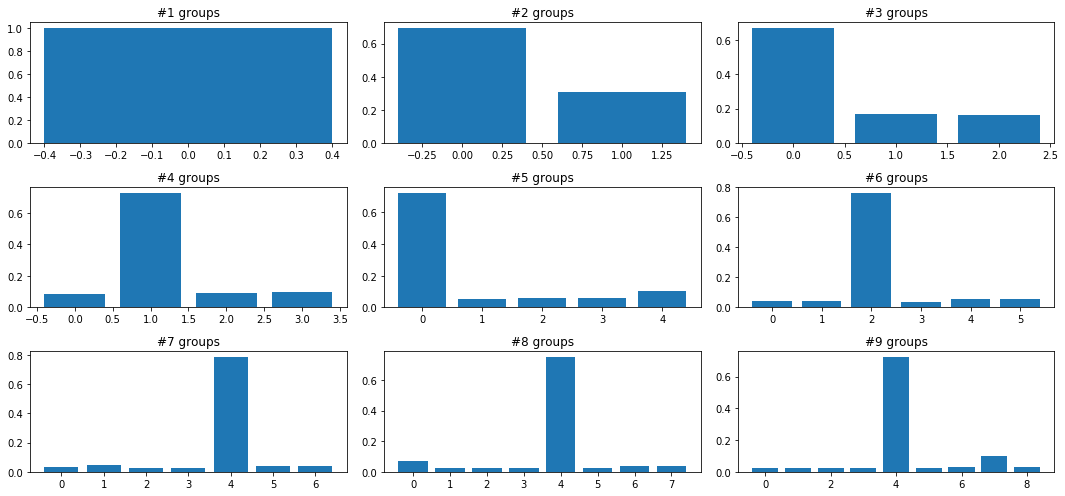

<Figure size 1080x360 with 0 Axes>

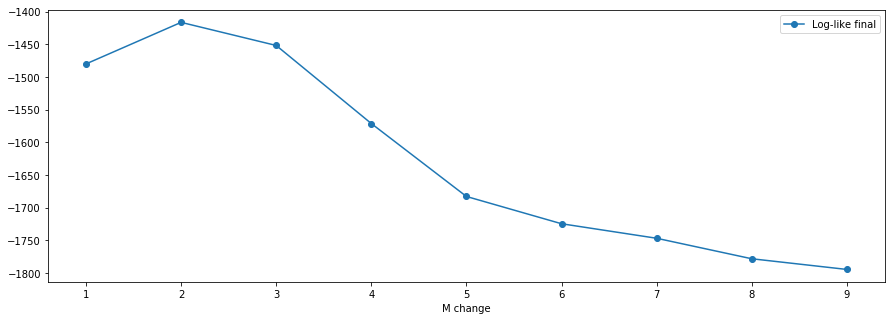

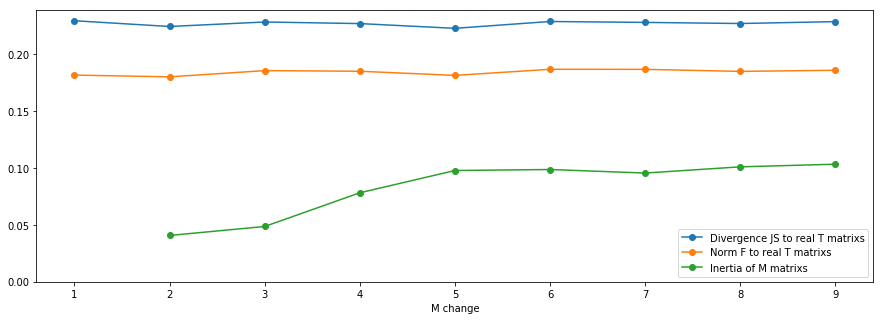

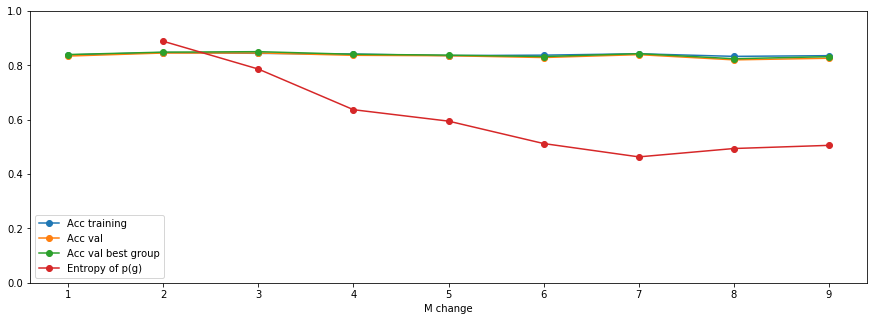

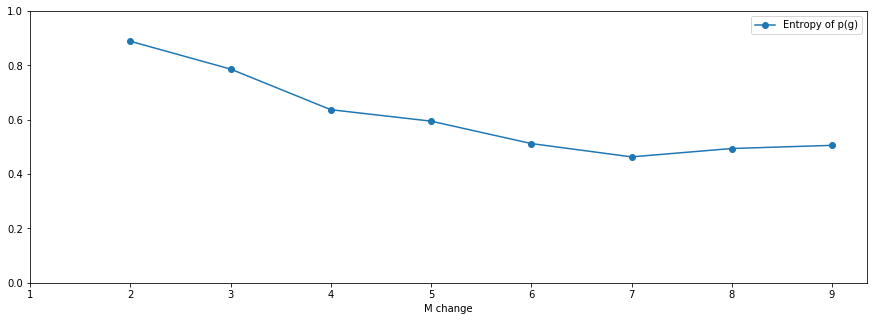

In [32]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [17]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

59


,#Groups,>=1 annotator,>=2 annotator,Used on annotators,Used on annotators limit >=0.01,Used on annotators limit >=0.05
0,1,1,1,1,1,1
1,2,1,1,1,1,1
2,3,1,1,1,1,1
3,4,2,1,1,2,1
4,5,1,1,1,1,1
5,6,1,1,1,1,1
6,7,2,1,1,2,1
7,8,2,2,1,2,2
8,9,2,1,1,2,1


1, 2 o 3...

In [12]:
M_seted = 3 #??

In [13]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.007374 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.54209745 0.17919026 0.8963465 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.75 sec)	logL: -2735.364	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2030.125	Tol1: 0.25782	Tol2: 0.31954	Tol3: 0.12483	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1814.559	Tol1: 0.10618	Tol2: 0.11492	Tol3: 0.21805	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.030	Tol1: 0.05265	Tol2: 0.07957	Tol3: 0.22625	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.378	Tol1: 0.02481	Tol2: 0.04384	Tol3: 0.21667	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1629.972	Tol1: 0.02768	Tol2: 0.02842	Tol3: 0.19545	
Finished training!
Initializing new EM...
Pre-train networ

M step: done,  E step: done //  (in 0.06 sec)	logL: -2415.436	Tol1: 0.34174	Tol2: 0.76893	Tol3: 0.75139	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2100.927	Tol1: 0.13021	Tol2: 0.15853	Tol3: 0.08621	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1945.437	Tol1: 0.07401	Tol2: 0.12224	Tol3: 0.17804	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1847.541	Tol1: 0.05032	Tol2: 0.11391	Tol3: 0.21738	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1782.516	Tol1: 0.03520	Tol2: 0.07555	Tol3: 0.22544	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.105	Tol1: 0.02716	Tol2: 0.06164	Tol3: 0.23024	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1701.124	Tol1: 0.01902	Tol2: 0.05025	Tol3: 0.22098	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1663.584	Tol1: 0.02207	Tol2: 0.03651	Tol3: 0.19792	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1635.103	Tol1: 0.01712	Tol

In [14]:
Z_train_p = gMixture_Global.base_model.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.base_model.predict(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

### Compare trained models

In [19]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [28]:
Z_train = mv_onehot.argmax(axis=-1)

*** Soft-Majority (Train with softMV) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.64198       0.64198
====  ======  ==========  ============


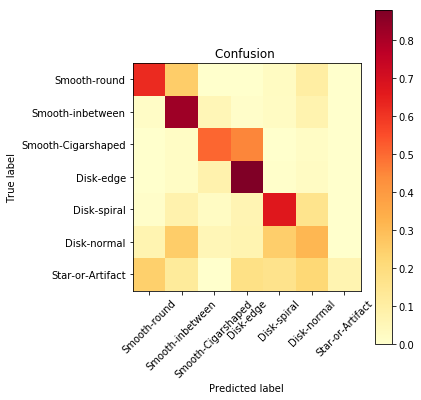

Test


In [36]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

prob_Yz0 = normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1')
plt.figure(figsize=(6,6))
plot_confusion_matrix(prob_Yz0, labels,title="Confusion ",text=False)

print("Test")
#results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
#results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
#aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False,p_z=Z_train_p)
#predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
c_M = gMixture_Global.get_confusionM()
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)